# Phân tích phim truyền thông và xã hội

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

## Phát biểu bài toán

## Giới thiệu về dữ liệu

## Các câu hỏi phân tích

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {      
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part1/CSM.xlsx", sheet = 1)
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie              : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year               : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings            : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre              : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross              : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget             : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens            : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel             : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment          : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views              : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes              : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes           : num [1:231] 425 61 34 132 610 

In [4]:
names(raw_data)[names(raw_data) == 'Aggregate Followers'] <- 'AggregateFollowers'

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 231  14

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Mỗi cột mang ý nghĩa gì?

In [7]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

Ý nghĩa từng cột:
- `Movie`: tên phim => Trong dữ liệu có kiểu dữ liệu chr => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Year`: năm phát hành => Trong dữ liệu có kiểu dữ liệu num => phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Ratings`: điểm đánh giá => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Genre`: thể loại phim => Trong dữ liệu có kiểu dữ liệu num => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Gross`: tổng doanh thu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Budget`: tổng chi phí => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Screens`: số rạp chiếu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Sequel`: phần phim => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Sentiment`: ý kiến khán giả => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization)=> Phù hợp
- `Views`: số lượt xem => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Likes`: số lượt thích => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Dislikes`: số lượt chê => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Comments`: số bình luận => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Aggregate Followers`: số người theo dõi => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [8]:
# 1. Genre 
is.factor(raw_data$Genre) #False 

[1] FALSE

In [9]:
# 2.Movie 
is.factor(raw_data$Movie) #False

[1] FALSE

In [10]:
# Modifications
processed_data <- raw_data
processed_data$Genre <- as.factor(processed_data$Genre)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [11]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate median
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Function to calculate lower quartile
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Function to calculate upper quartile
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [12]:
# Select numerical columns
num_col_info_df <- as.data.frame(processed_data) %>% select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- as.data.frame(processed_data) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable           missing     min      lower     median      upper       max
   <chr>                <dbl>   <dbl>      <dbl>      <dbl>      <dbl>     <dbl>
 1 Year                   0    2014       2014       2014       2015      2.02e3
 2 Ratings                0       3.1        5.8        6.5        7.1    8.7 e0
 3 Gross                  0    2470   10300000   37400000   89350000      6.43e8
 4 Budget                 0.4 70000    9000000   28000000   65000000      2.5 e8
 5 Screens                4.3     2        449       2777       3372      4.32e3
 6 Sequel                 0       1          1          1          1      7   e0
 7 Sentiment              0     -38          0          0          5.5    2.9 e1
 8 Views                  0     698     623302    2409338    5217380.     3.26e7
 9 Likes                  0       1       1776.      6096      15248.     3.71e5
10 Dislikes               0       0        106.       341        698.     1.40e4
11 Commen

**Nhận xét**
- Dữ liệu có hiện tượng missing values.
- Cụ thể, ta thấy biến `Aggregate Followers` có tỷ lệ missing 15.2%, biến `Screens` có tỷ lệ 4.3% và biến `Budget` có tỷ lệ missing 0.4%.
- Có những bộ phim không có likes/ dislikes/ comments, ta sẽ loại bỏ những dòng này.

In [13]:
processed_data <- processed_data %>% filter(Likes != 0)
processed_data <- processed_data %>% filter(Dislikes != 0)
processed_data <- processed_data %>% filter(Comments != 0)

Kiểm tra lại với hàm `summary`

In [14]:
print(summary(as.data.frame(processed_data) %>% select_if(is.numeric)))

      Year         Ratings          Gross               Budget         
 Min.   :2014   Min.   :3.100   Min.   :     2470   Min.   :    70000  
 1st Qu.:2014   1st Qu.:5.800   1st Qu.: 10525000   1st Qu.:  9000000  
 Median :2014   Median :6.500   Median : 37650000   Median : 28000000  
 Mean   :2014   Mean   :6.435   Mean   : 68185216   Mean   : 47688067  
 3rd Qu.:2015   3rd Qu.:7.100   3rd Qu.: 89375000   3rd Qu.: 65000000  
 Max.   :2015   Max.   :8.700   Max.   :643000000   Max.   :250000000  
                                                    NA's   :1          
    Screens         Sequel        Sentiment           Views         
 Min.   :   2   Min.   :1.000   Min.   :-38.000   Min.   :     698  
 1st Qu.: 461   1st Qu.:1.000   1st Qu.:  0.000   1st Qu.:  702823  
 Median :2777   Median :1.000   Median :  0.000   Median : 2529698  
 Mean   :2217   Mean   :1.341   Mean   :  2.845   Mean   : 3794866  
 3rd Qu.:3372   3rd Qu.:1.000   3rd Qu.:  6.000   3rd Qu.: 5222041  
 Max.   :4

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Ta xem xét số lượng phần tử duy nhất (unique) của biến Movie

In [15]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate number of unique values
num_values <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

# Function to calculate value ratios
value_ratios <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

# Select categorical columns (assuming character and factor columns as categorical)
cat_col_info_df <- processed_data %>%
  select_if(~ is.character(.) || is.factor(.))

# Function to aggregate results for each column
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Apply the aggregation function
cat_col_info_df <- aggregate_results(cat_col_info_df)

# Print the result
print(cat_col_info_df)

      column missing_ratio num_values value_ratios
Movie  Movie             0        226 0.4, 0.4....
Genre  Genre             0         11 28.3, 4.....


Ta thấy số lượng phần tử đơn trong Movie bằng số lượng record trong dữ liệu. Ta có thể loại bỏ biến này trong quá trình phân tích phía sau.

In [16]:
length(unique(processed_data$Movie))

[1] 226

Ta thấy biến `Genre` có 11 giá trị đơn, bao gồm 8, 1, 3, 10, 15, 12, 9, 2, 7, 6, 4.

In [17]:
unique(processed_data$Genre)
length(unique(processed_data$Genre))

[1] 8  1  3  10 15 12 9  2  7  6  4 
Levels: 1 2 3 4 6 7 8 9 10 12 15

[1] 11

In [18]:
# df <- data.frame(
#     year = unique(raw_data$Year),
#     percentage = c(70.6, 29.4)
# )

# # colnames(plot_df) <- c("Value", "Percentage")
# # plot_df

# bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
# geom_bar(width = 1, stat = "identity")
# pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
# pie

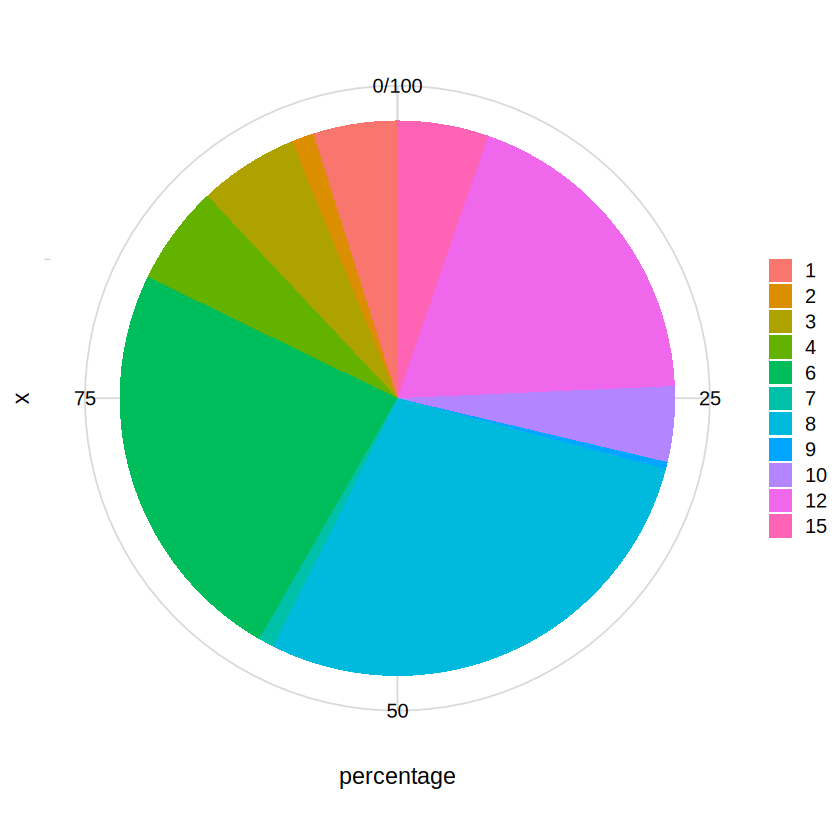

In [19]:
df <- data.frame(
    year = unique(processed_data$Genre),
    percentage = c(t(as.data.frame(cat_col_info_df$value_ratios[[2]])[1, ]))
)

bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
pie

### Xử lý dữ liệu bị thiếu

Ta nhìn lại tỷ lệ missing values

In [20]:
print(apply(processed_data, 2, function(x) {sum(is.na(x))/length(x)*100}))

             Movie               Year            Ratings              Genre 
         0.0000000          0.0000000          0.0000000          0.0000000 
             Gross             Budget            Screens             Sequel 
         0.0000000          0.4424779          3.9823009          0.0000000 
         Sentiment              Views              Likes           Dislikes 
         0.0000000          0.0000000          0.0000000          0.0000000 
          Comments AggregateFollowers 
         0.0000000         15.4867257 


,Movie,Year,Ratings,Genre,Gross,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Budget,Screens,AggregateFollowers,
183,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
33,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
7,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,2
1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
,0,0,0,0,0,0,0,0,0,0,0,1,9,35,45


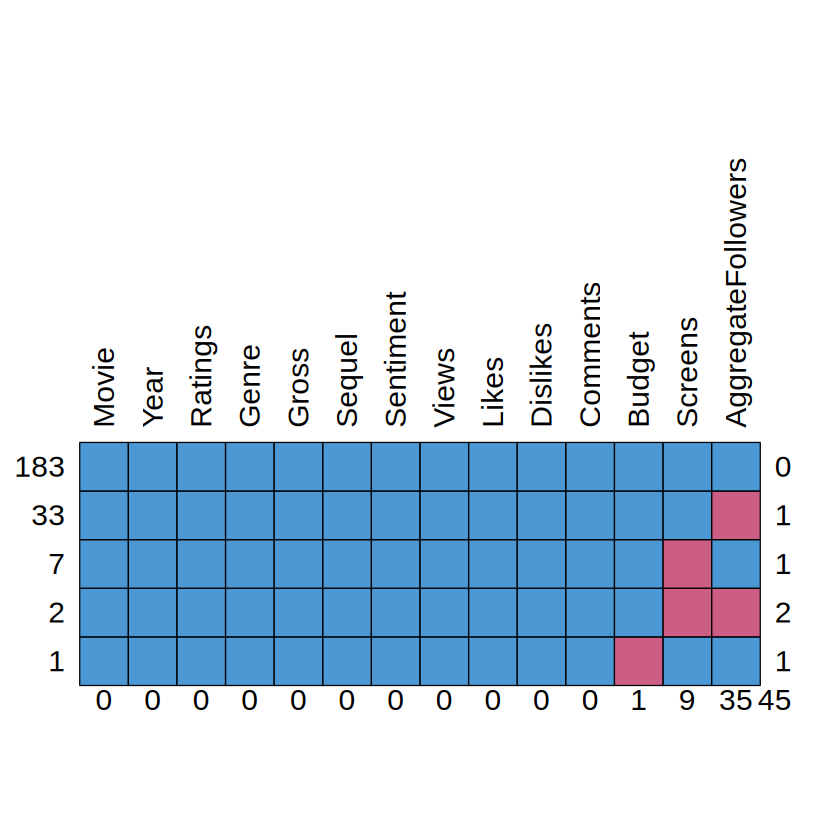

In [21]:
par(mar = c(5, 5, 2, 2), cex = 1.5)
md_plot <- md.pattern(processed_data, plot = TRUE, rotate.names = TRUE)
md_plot

Giá trị 0 ám chỉ giá trị bị thiếu. Lấy ví dụ, biến `Budget` có chứa 1 dòng bị missing value, `Screens` có 10 dòng bị missing values, `Aggregate Followers` có 35 dòng bị missing values.

In [22]:
md.pairs(processed_data)

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
Movie,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Year,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Ratings,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Genre,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Gross,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Budget,225,225,225,225,225,225,216,225,225,225,225,225,225,190
Screens,217,217,217,217,217,216,217,217,217,217,217,217,217,184
Sequel,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Sentiment,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Views,226,226,226,226,226,225,217,226,226,226,226,226,226,191


Bằng cách dùng lên trên, ta có được bốn bảng bao gồm `rr`, `rm`, `mr`, và `mm`
- Bảng `rr` (response-response) cho ta biết có bao nhiêu điểm dữ liệu được quan sát.
- Bảng `rm` (response-missing) cho ta biết các dòng quan sát được, cột bị thiếu.
- Bảng `mr` (missing -response) cho ta biết các dòng bị thiếu, cột quan sát được.
- Bảng `mm` (missing -missing) cho ta biết các hai, dòng và cột bị thiếu. 

Ta thử trực quan hóa bằng hàm `marginplot`. Một cách đơn giản thì hàm này trực quan phân phối của dữ liệu bị thiếu của một biến trong một biến khác (màu đỏ), và phân phối dữ liệu không bị thiếu (màu xanh). Ở đây, ta thử nghiệm ba trường hợp
- `Budget` và `Screens`
- `Budget` và `Aggregate Followers`
- `Screens` và `Aggregate Followers`

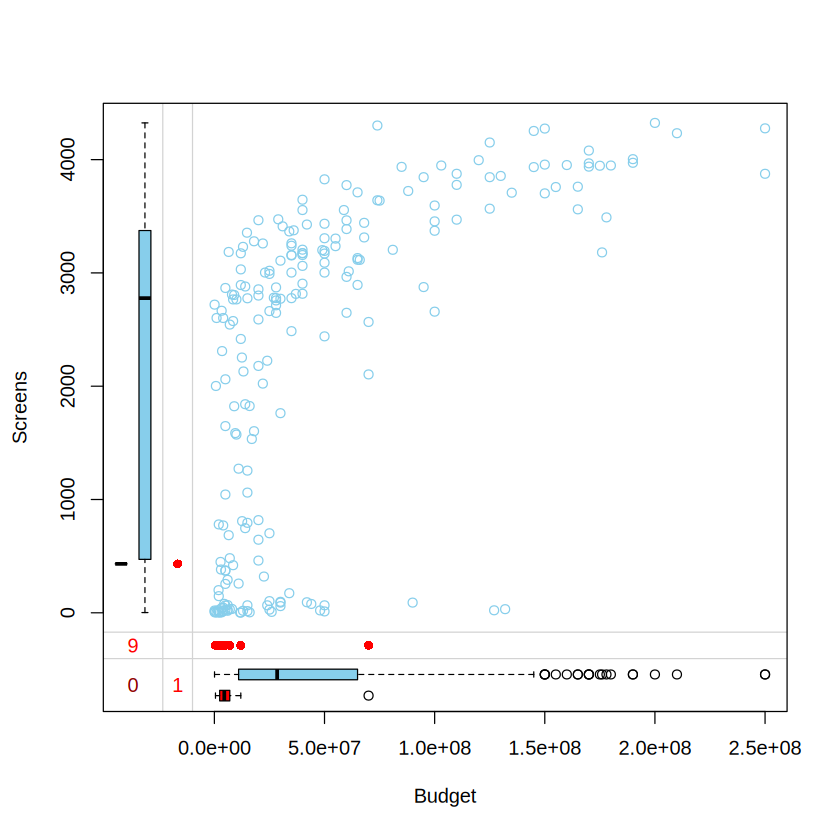

In [23]:
marginplot(processed_data[, c('Budget', 'Screens')])

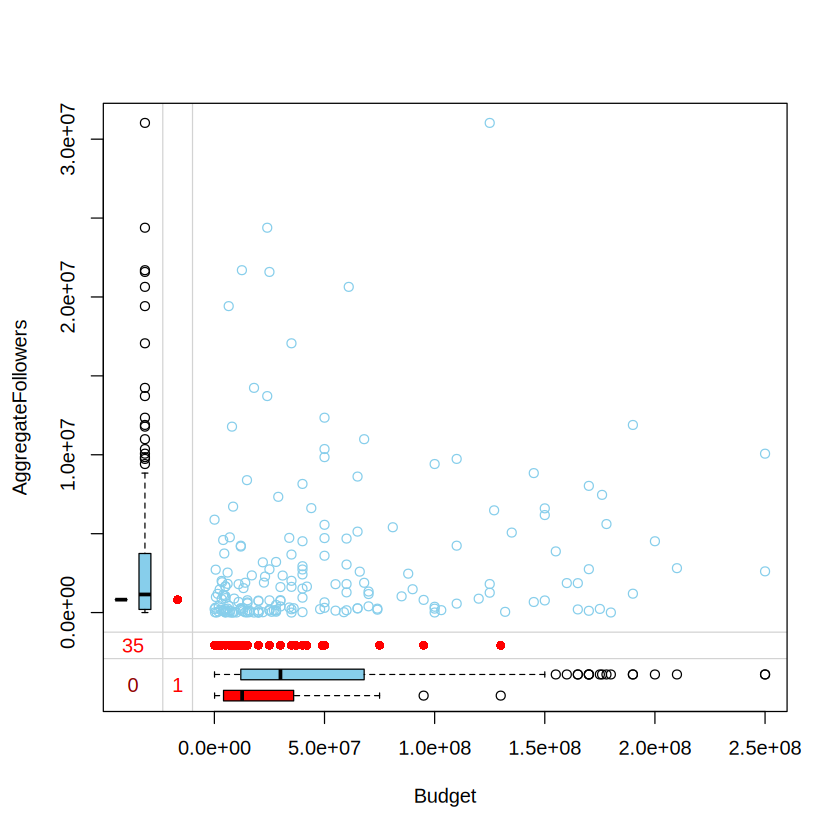

In [24]:
marginplot(processed_data[, c('Budget', 'AggregateFollowers')])

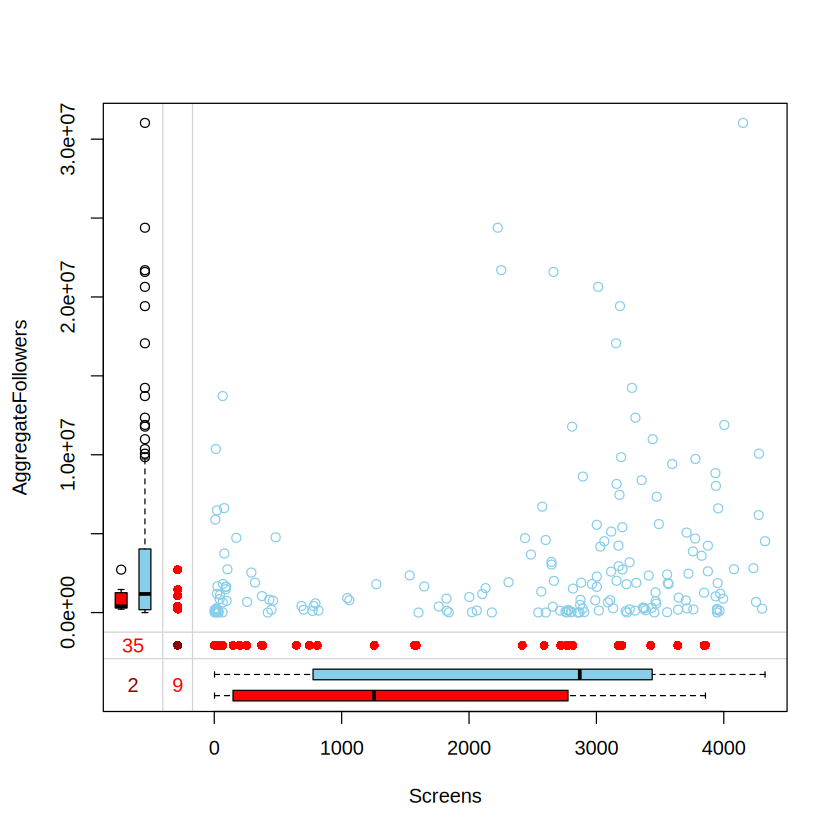

In [25]:
marginplot(processed_data[, c('Screens', 'AggregateFollowers')])

In [26]:
imputed_Budget <- data.frame(
  original = processed_data$Budget,
  imputed_zero = replace(processed_data$Budget, is.na(processed_data$Budget), 0),
  imputed_mean = replace(processed_data$Budget, is.na(processed_data$Budget), mean(processed_data$Budget, na.rm = TRUE)),
  imputed_median = replace(processed_data$Budget, is.na(processed_data$Budget), median(processed_data$Budget, na.rm = TRUE))
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


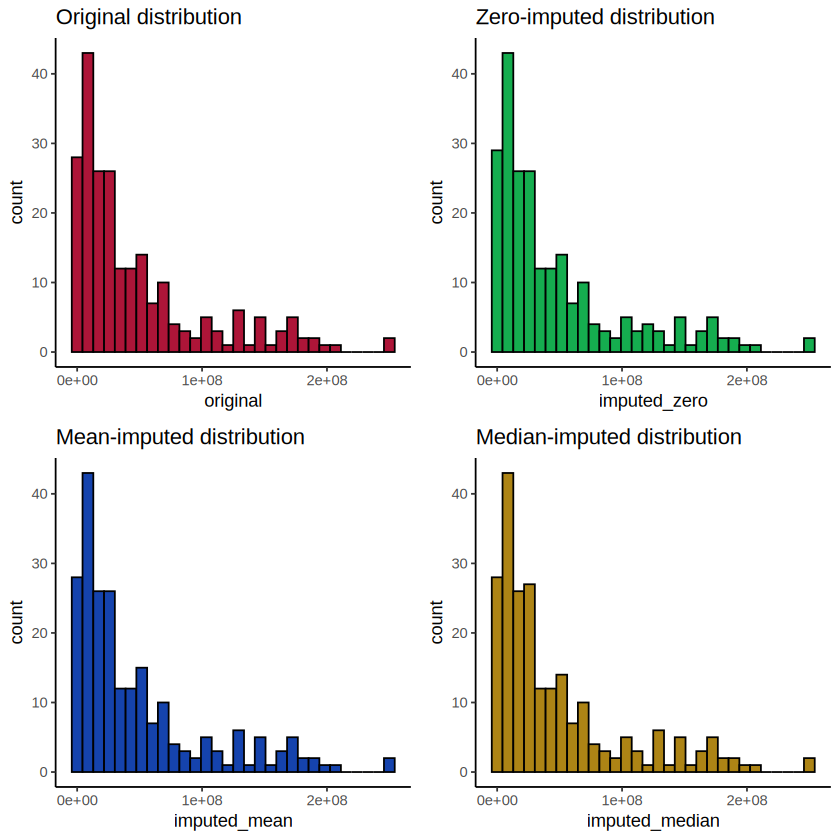

In [27]:
h1 <- ggplot(imputed_Budget, aes(x = original)) +
  geom_histogram(fill = "#ad1538", color = "#000000", position = "identity") +
  ggtitle("Original distribution") +
  theme_classic()
h2 <- ggplot(imputed_Budget, aes(x = imputed_zero)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Zero-imputed distribution") +
  theme_classic()
h3 <- ggplot(imputed_Budget, aes(x = imputed_mean)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Mean-imputed distribution") +
  theme_classic()
h4 <- ggplot(imputed_Budget, aes(x = imputed_median)) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("Median-imputed distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, nrow = 2, ncol = 2, rel_widths = c(1, 1), rel_heights = c(1, 1))

Do biến `Budget` chỉ có một dòng bị thiếu nên khi sử dụng imputation bằng các trường hợp  mean, zero và median thì phân phối của biến này không có gì thay đổi. Ta sử dụng impute bằng mean để xử lý.

In [28]:
processed_data <- processed_data %>%
  mutate(Budget = ifelse(is.na(Budget), mean(Budget, na.rm = TRUE), Budget))

In [29]:
imputed_Screens <- data.frame(
  original = processed_data$Screens,
  imputed_zero = replace(processed_data$Screens, is.na(processed_data$Screens), 0),
  imputed_mean = replace(processed_data$Screens, is.na(processed_data$Screens), mean(processed_data$Screens, na.rm = TRUE)),
  imputed_median = replace(processed_data$Screens, is.na(processed_data$Screens), median(processed_data$Screens, na.rm = TRUE))
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


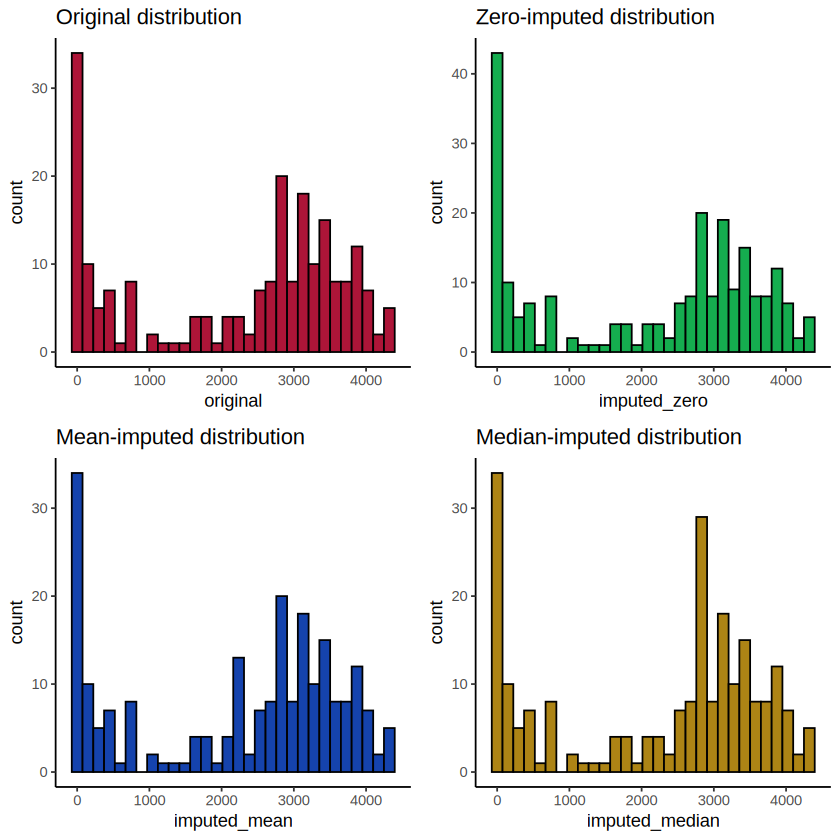

In [30]:
h1 <- ggplot(imputed_Screens, aes(x = original)) +
  geom_histogram(fill = "#ad1538", color = "#000000", position = "identity") +
  ggtitle("Original distribution") +
  theme_classic()
h2 <- ggplot(imputed_Screens, aes(x = imputed_zero)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Zero-imputed distribution") +
  theme_classic()
h3 <- ggplot(imputed_Screens, aes(x = imputed_mean)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Mean-imputed distribution") +
  theme_classic()
h4 <- ggplot(imputed_Screens, aes(x = imputed_median)) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("Median-imputed distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, nrow = 2, ncol = 2, rel_widths = c(1, 1), rel_heights = c(1, 1))

Ta thấy khi sử dụng mean-imputed, phân phối của biến đã được biến đổi tương đối gần giống với biến ban đầu. Do đó, ta sẽ dụng mean-imputed.

In [31]:
processed_data <- processed_data %>%
  mutate(Screens = ifelse(is.na(Screens), mean(Screens, na.rm = TRUE), Screens))

In [32]:
imputed_Aggregate_Followers <- data.frame(
  original = processed_data$AggregateFollowers,
  imputed_zero = replace(processed_data$AggregateFollowers, is.na(processed_data$AggregateFollowers), 0),
  imputed_mean = replace(processed_data$AggregateFollowers, is.na(processed_data$AggregateFollowers), mean(processed_data$AggregateFollowers, na.rm = TRUE)),
  imputed_median = replace(processed_data$AggregateFollowers, is.na(processed_data$AggregateFollowers), median(processed_data$AggregateFollowers, na.rm = TRUE))
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


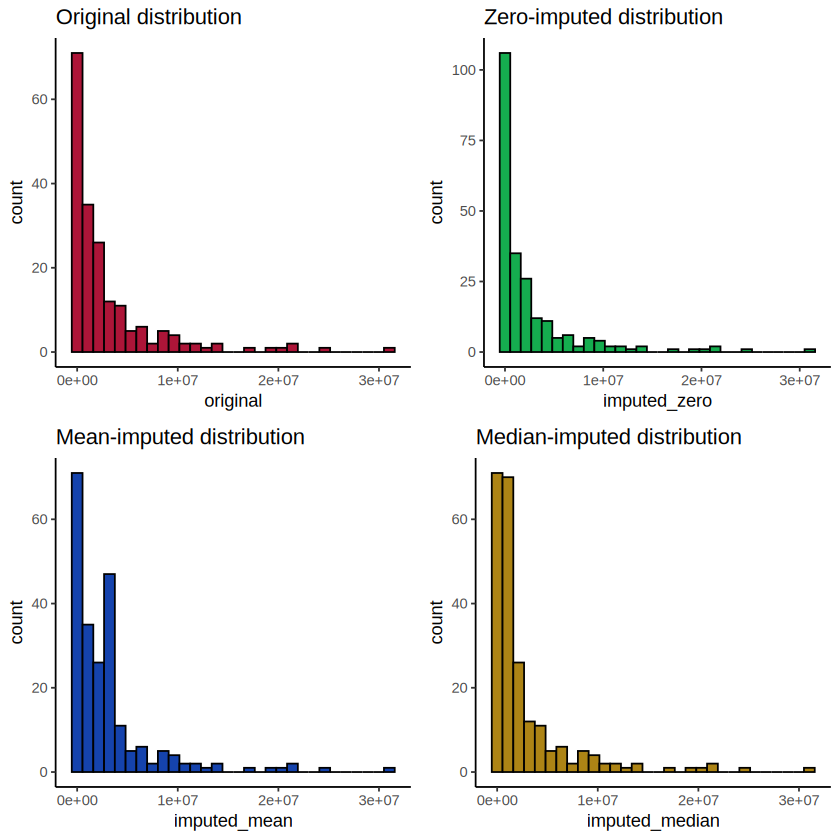

In [33]:
h1 <- ggplot(imputed_Aggregate_Followers, aes(x = original)) +
  geom_histogram(fill = "#ad1538", color = "#000000", position = "identity") +
  ggtitle("Original distribution") +
  theme_classic()
h2 <- ggplot(imputed_Aggregate_Followers, aes(x = imputed_zero)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Zero-imputed distribution") +
  theme_classic()
h3 <- ggplot(imputed_Aggregate_Followers, aes(x = imputed_mean)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Mean-imputed distribution") +
  theme_classic()
h4 <- ggplot(imputed_Aggregate_Followers, aes(x = imputed_median)) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("Median-imputed distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, nrow = 2, ncol = 2, rel_widths = c(1, 1), rel_heights = c(1, 1))

Ta thấy khi sử dụng median-imputed, phân phối của biến sau khi được biến đổi tốt và gần giống với ban đầu hơn. Do đó, ta có thể chọn median-imputed.

In [34]:
processed_data <- processed_data %>%
  mutate(AggregateFollowers = ifelse(is.na(AggregateFollowers), median(AggregateFollowers, na.rm = TRUE), AggregateFollowers))

Kiểm tra lại một lần nữa trước khi xử lý tiếp

In [35]:
print(apply(processed_data, 2, function(x) {sum(is.na(x))/length(x)*100}))

             Movie               Year            Ratings              Genre 
                 0                  0                  0                  0 
             Gross             Budget            Screens             Sequel 
                 0                  0                  0                  0 
         Sentiment              Views              Likes           Dislikes 
                 0                  0                  0                  0 
          Comments AggregateFollowers 
                 0                  0 


### Thử xử lý missing value bằng PCA

In [36]:
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

In [37]:
nPCs <- estim_ncpPCA(raw_data[, -c(1)])
print(nPCs)

$ncp
[1] 2

$criterion
           0            1            2            3            4            5 
8.461633e+14 6.896501e+14 3.453184e+14 4.072345e+14 4.950558e+14 5.955508e+14 



In [38]:
processed_data2 <- imputePCA(raw_data[, -c(1)], ncp = nPCs$ncp, scale = TRUE)
processed_data2 <- processed_data2$completeObs

In [39]:
print(apply(processed_data2, 2, function(x) {sum(is.na(x))/length(x)*100}))

              Year            Ratings              Genre              Gross 
                 0                  0                  0                  0 
            Budget            Screens             Sequel          Sentiment 
                 0                  0                  0                  0 
             Views              Likes           Dislikes           Comments 
                 0                  0                  0                  0 
AggregateFollowers 
                 0 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


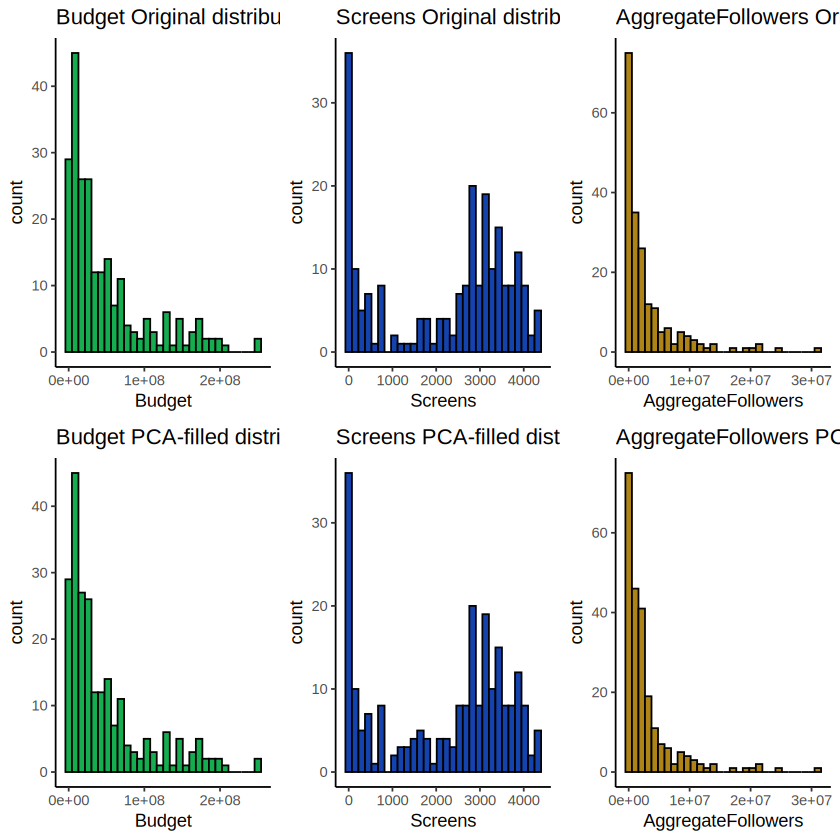

In [40]:
h1 <- ggplot(raw_data, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget Original distribution") +
  theme_classic()
h2 <- ggplot(raw_data, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens Original distribution") +
  theme_classic()
h3 <- ggplot(raw_data, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers Original distribution") +
  theme_classic()

  
h4 <- ggplot(processed_data2, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget PCA-filled distribution") +
  theme_classic()
h5 <- ggplot(processed_data2, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens PCA-filled distribution") +
  theme_classic()
h6 <- ggplot(processed_data2, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers PCA-filled distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, h5, h6, nrow = 2, ncol = 3, rel_widths = c(1, 1), rel_heights = c(1, 1))

Đến đây, ta thấy PCA fill missing value rất tốt. Ta sẽ sử dụng nó.

## Xử lý đa cộng tuyến

In [41]:
processed_data_final <- as.data.frame(processed_data2)
processed_data_final <- processed_data_final %>% filter(Likes != 0)
processed_data_final <- processed_data_final %>% filter(Dislikes != 0)
processed_data_final <- processed_data_final %>% filter(Comments != 0)

# processed_data_final <- raw_data[,c(1, 2)]

# # processed_data_final$Genre <- c(raw_data$Genre)  
# # processed_data_final$Year <- c(raw_data$Year)  

# # processed_data_final <- processed_data[, -c(1)]

# processed_data_final

In [42]:
model <- lm(Gross ~ ., data = processed_data_final)

vif_values <- vif(model)
print(vif_values)

# Interpret the results
if(any(vif_values > 10)) {
  cat("Warning: High multicollinearity detected.\n")
} else {
  cat("No high multicollinearity detected.\n")
}

              Year            Ratings              Genre             Budget 
          1.276641           1.289311           1.124932           2.198357 
           Screens             Sequel          Sentiment              Views 
          1.831738           1.411014           1.124948           3.923073 
             Likes           Dislikes           Comments AggregateFollowers 
          8.144422           3.189681           9.022362           1.153832 
No high multicollinearity detected.


In [43]:
# Dữ liệu không có hiện tượng đa cộng tuyến, nên ta sẽ gán lại biến
cleaned_df <- processed_data_final

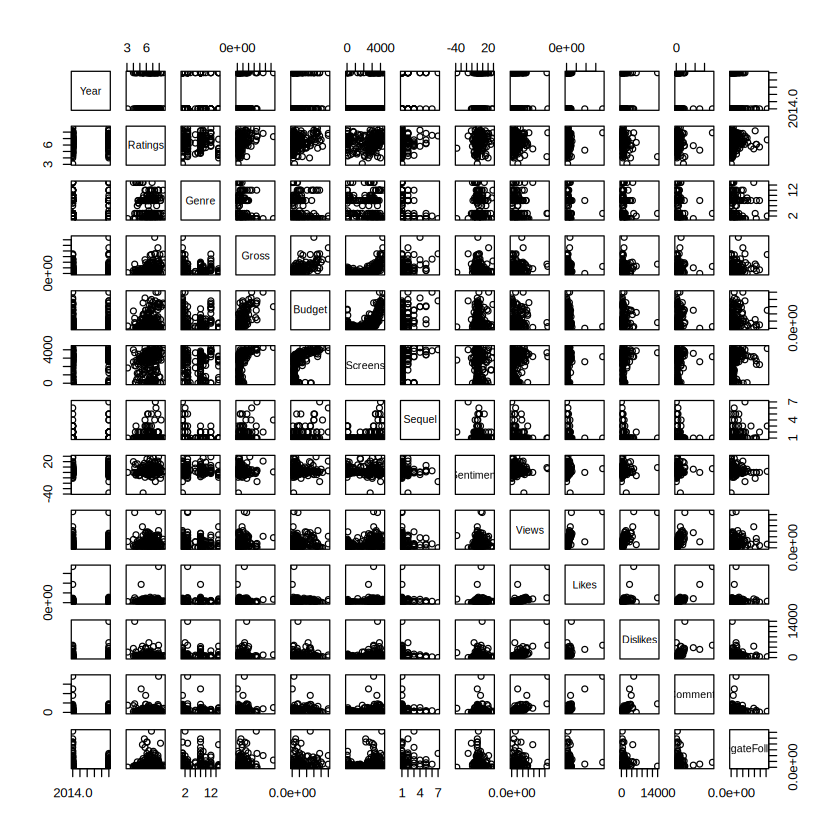

In [44]:
plot(cleaned_df)

## Khảo sát ngoại lai

In [45]:
# Function to identify and remove outliers using Cook's distance
identify_and_remove_outliers_cooks <- function(df, model) {
  # Check if the dataframe and model are provided
  if (!is.data.frame(df)) {
    stop("Input 'df' must be a dataframe")
  }
  if (!inherits(model, "lm")) {
    stop("Input 'model' must be a linear regression model (lm)")
  }
  
  # Obtain Cook's distance
  cooks_dist <- cooks.distance(model)
  
  # Find outliers based on a threshold
  outlier_threshold <- 4 / nrow(df) # Adjust the threshold as needed
  outliers <- which(cooks_dist > outlier_threshold)
  
  # Remove outliers from the dataframe
  df_cleaned <- df[-outliers, ]
  
  # Print Cook's distance and identified outliers
  cat("Cook's distance:\n")
  print(cooks_dist)
  cat("\nIdentified outliers:\n")
  print(outliers)
  
  return(df_cleaned)
}

# model <- lm(Gross ~ ., data = cleaned_df)
# cleaned_df <- identify_and_remove_outliers_cooks(cleaned_df, model)

# dim(cleaned_df)
# dim(df_cleaned)

In [46]:
# Function to detect outliers using IQR, excluding specified columns
iqr_detect_outliers <- function(df, exclude_columns = NULL) {
  # If no columns are specified to exclude, set it to an empty character vector
  if (is.null(exclude_columns)) {
    exclude_columns <- character(0)
  }
  
  # Loop through each column in the dataframe
  for (column_name in names(df)) {
    # Skip the columns specified to be excluded
    if (column_name %in% exclude_columns) {
      next
    }
    
    # Check if the column is numeric
    if (is.numeric(df[[column_name]])) {
      # Calculate Q1, Q3, and IQR
      Q1 <- quantile(df[[column_name]], 0.25, na.rm = TRUE)
      Q3 <- quantile(df[[column_name]], 0.75, na.rm = TRUE)
      IQR <- Q3 - Q1
      
      # Determine outlier boundaries
      lower_bound <- Q1 - 1.5 * IQR
      upper_bound <- Q3 + 1.5 * IQR
      
      # Remove outliers
      df <- df %>%
        filter(df[[column_name]] >= lower_bound & df[[column_name]] <= upper_bound)
    }
  }
  
  return(df)
}

# Example usage
# Assuming df is your data frame and you want to exclude the "Sequel" column
# df_cleaned <- iqr_detect_outliers(cleaned_df, exclude_columns = "Sequel")

df_cleaned <- iqr_detect_outliers(cleaned_df, exclude_columns = "Sequel")

# dim(cleaned_df)
# dim(df_cleaned)

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [47]:
names(cleaned_df)

[1] "Year"               "Ratings"            "Genre"             
 [4] "Gross"              "Budget"             "Screens"           
 [7] "Sequel"             "Sentiment"          "Views"             
[10] "Likes"              "Dislikes"           "Comments"          
[13] "AggregateFollowers"

### Phân tích biến `Ratings`

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


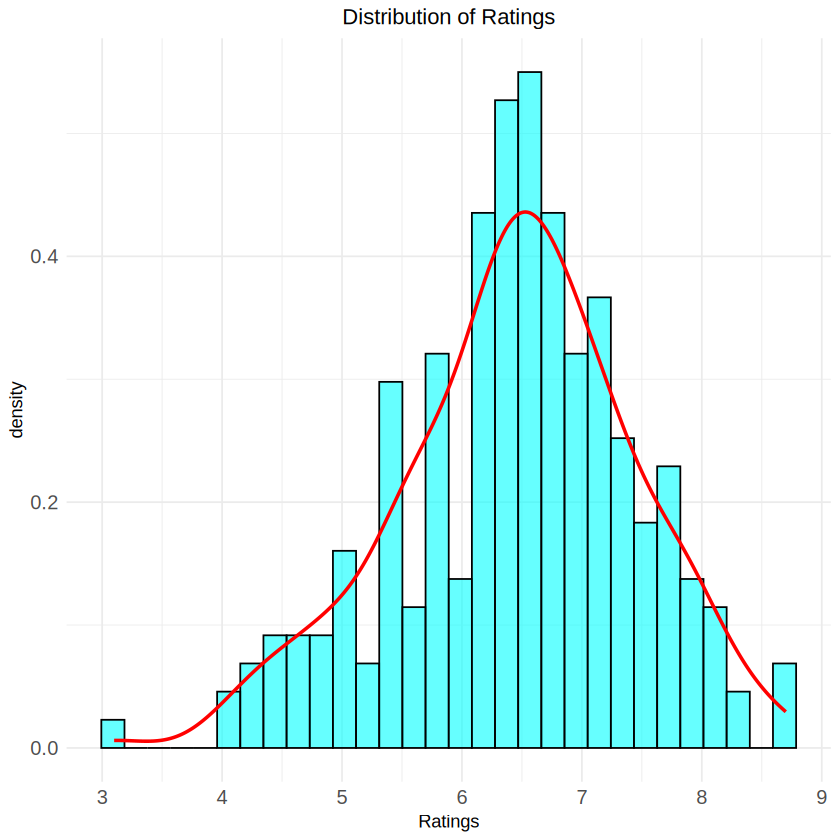

In [48]:
# tidy_empirical(train$Ratings) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Ratings)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Ratings") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ trên, ta thấy phân phối của biến `Ratings` tương đối chuẩn, ta không cần phải tiền xử lý nó.

[1] "Optimal lambda:  1.71717171717172"


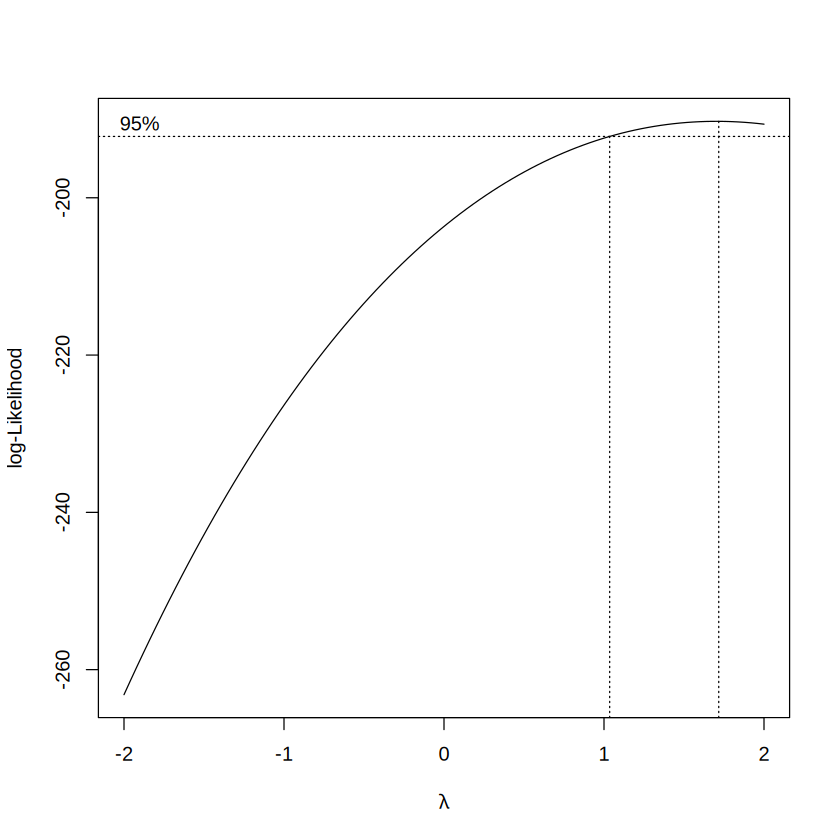

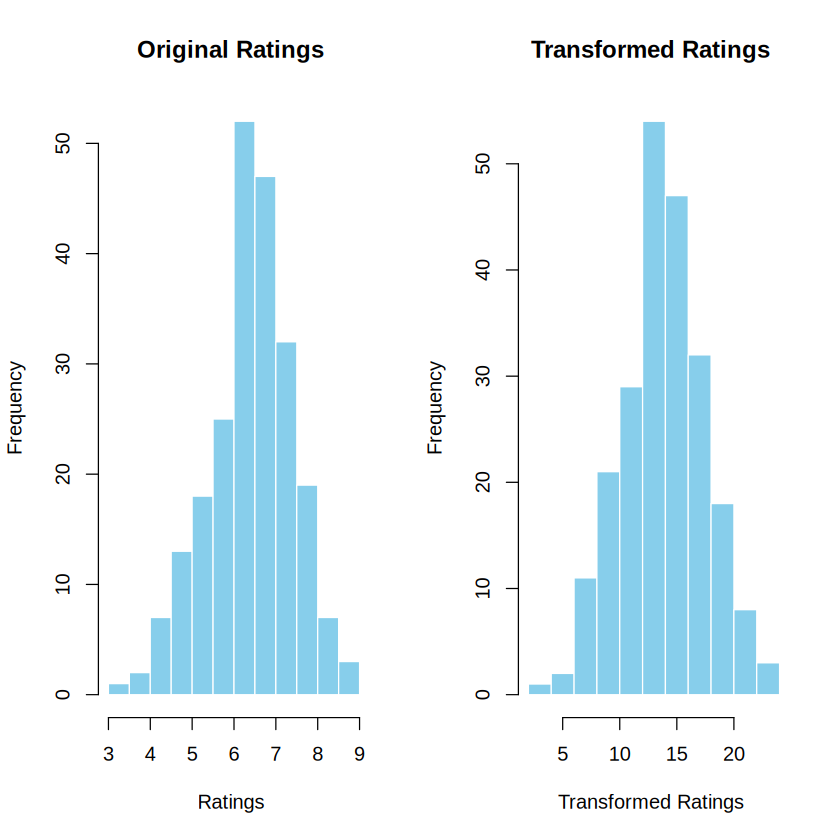

In [49]:
# Để chắc ăn, dùng box-cox
response_variable <- cleaned_df$Ratings 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Ratings ", xlab = "Ratings ", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Ratings ", xlab = "Transformed Ratings ", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [50]:
cleaned_df$Ratings <- transformed_response

### Phân tích biến `Gross`

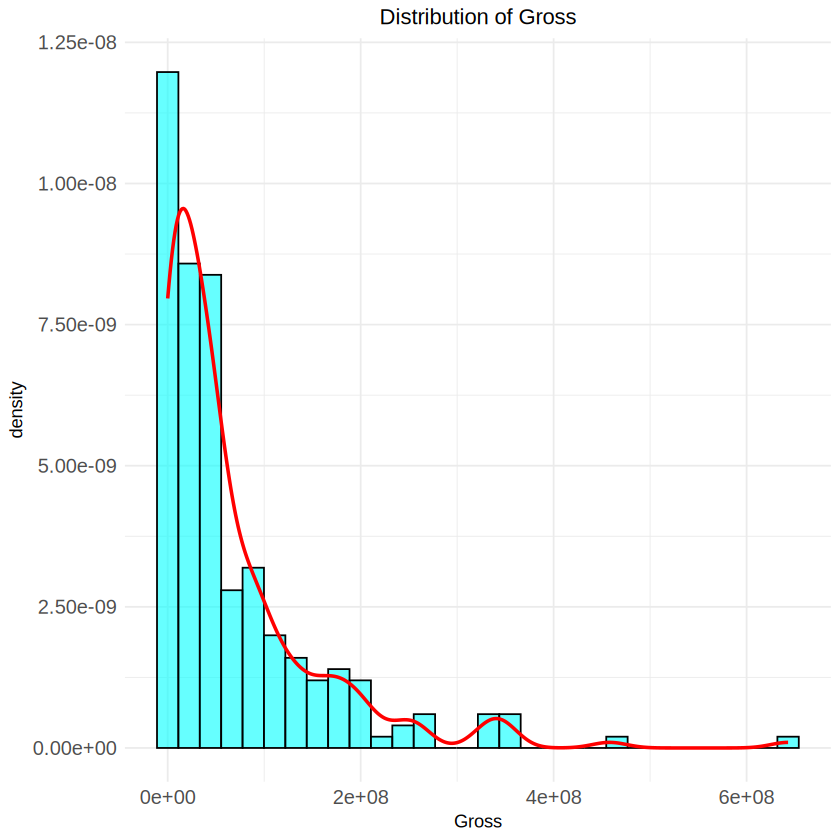

In [51]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ, ta thấy phân phối của biến `Gross` bị lệch phải.

Ta thử sử dụng log-transform nó.

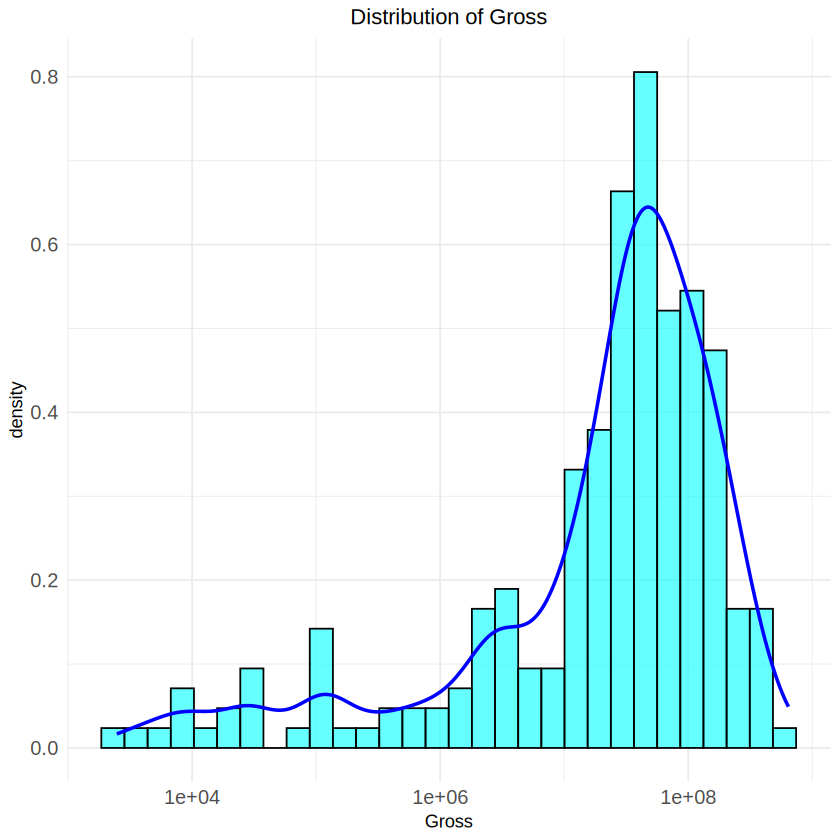

In [52]:
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Ta nhận thấy sau khi sử dụng log-transform, dữ liệu bị lệch trái. Do đó, ta thử sử dụng box-cox.

[1] "Optimal lambda:  0.262626262626263"


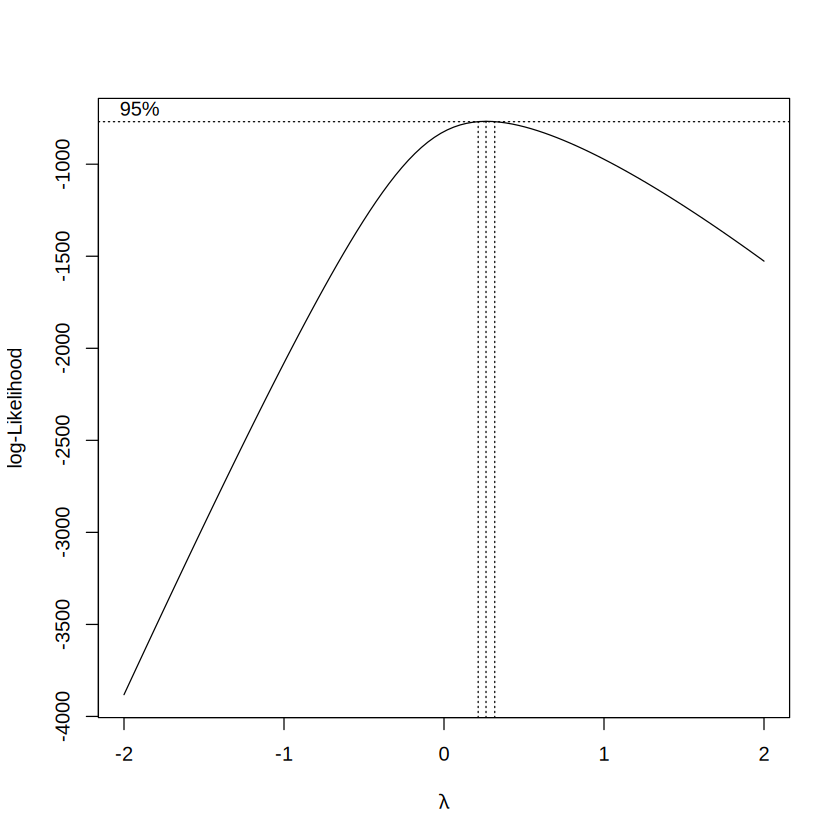

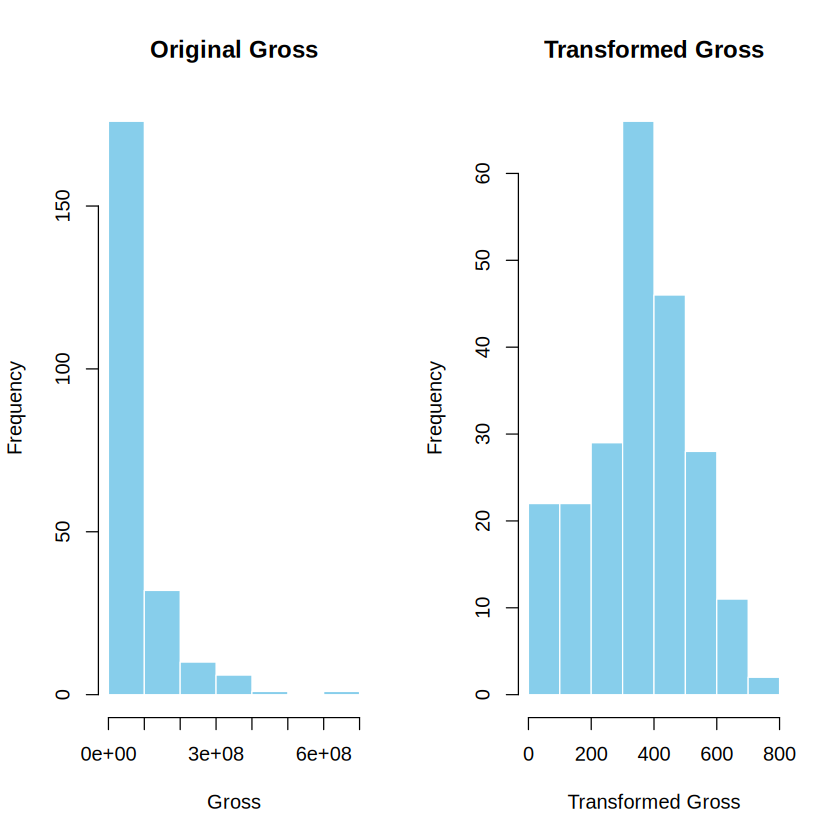

In [53]:
response_variable <- cleaned_df$Gross 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Gross", xlab = "Gross", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Gross", xlab = "Transformed Gross", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

Ta có được giá trị lambda tối ưu là 0.33 và sử dụng giá trị này để biến đổi biến `Gross`. Biểu đồ histogram phía bên dưới thể hiện phân phối của biến này trước và sau khi biến đổi. Dễ dàng thấy được, sau khi biến đổi, biến này đã tương đối chuẩn hơn.

Ta thực hiện gán giá trị đã được biến đổi vào dataframe.

In [54]:
cleaned_df$Gross <- transformed_response

### Phân tích biến `Budget`

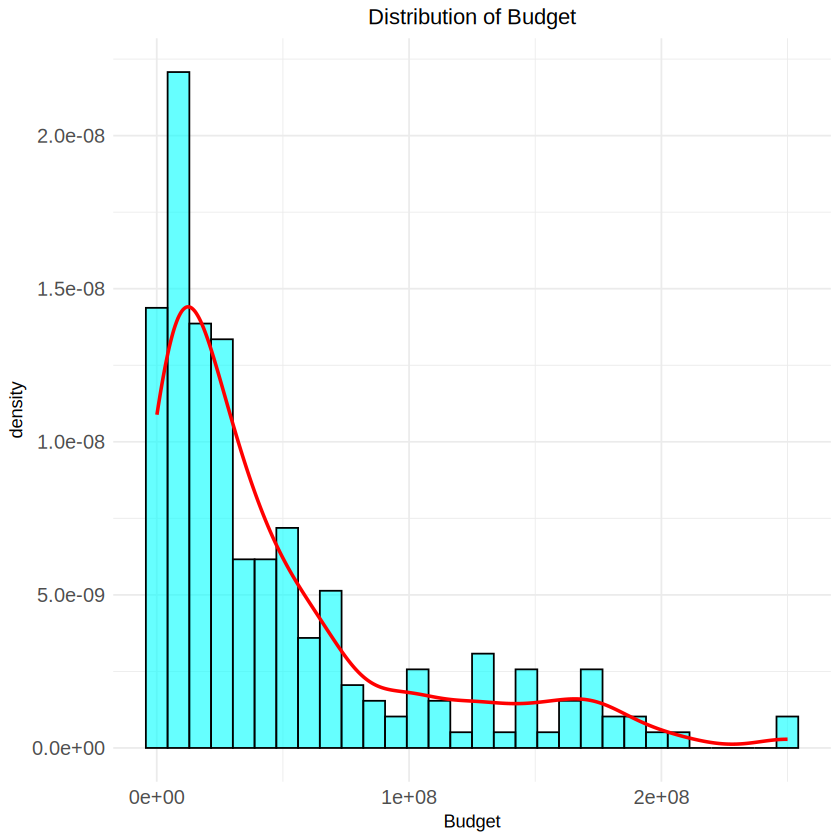

In [55]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Budget)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Budget") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.222222222222222"


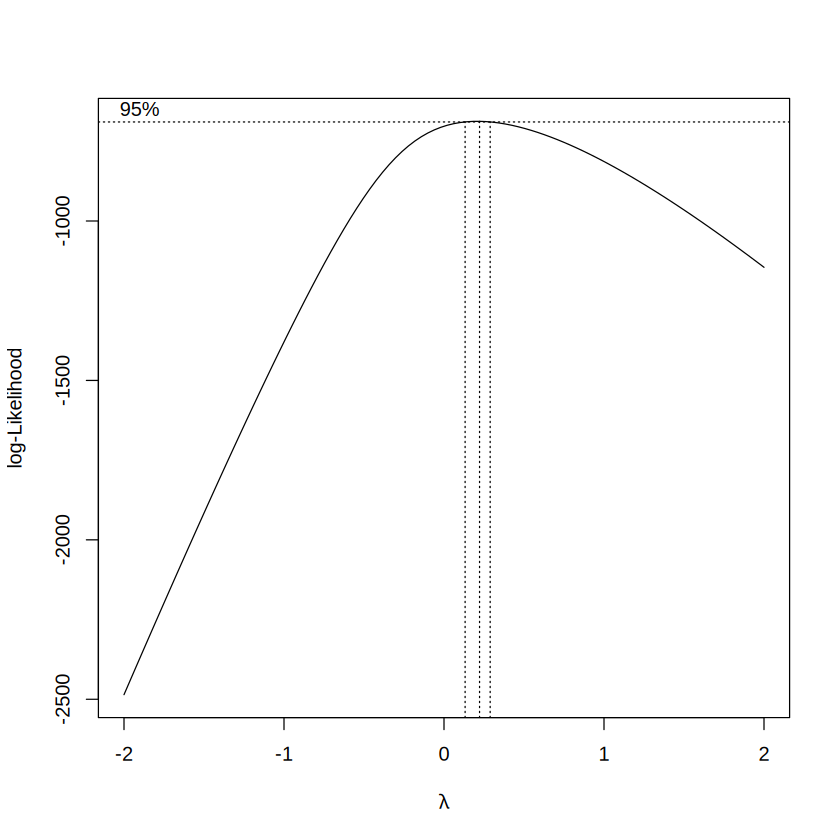

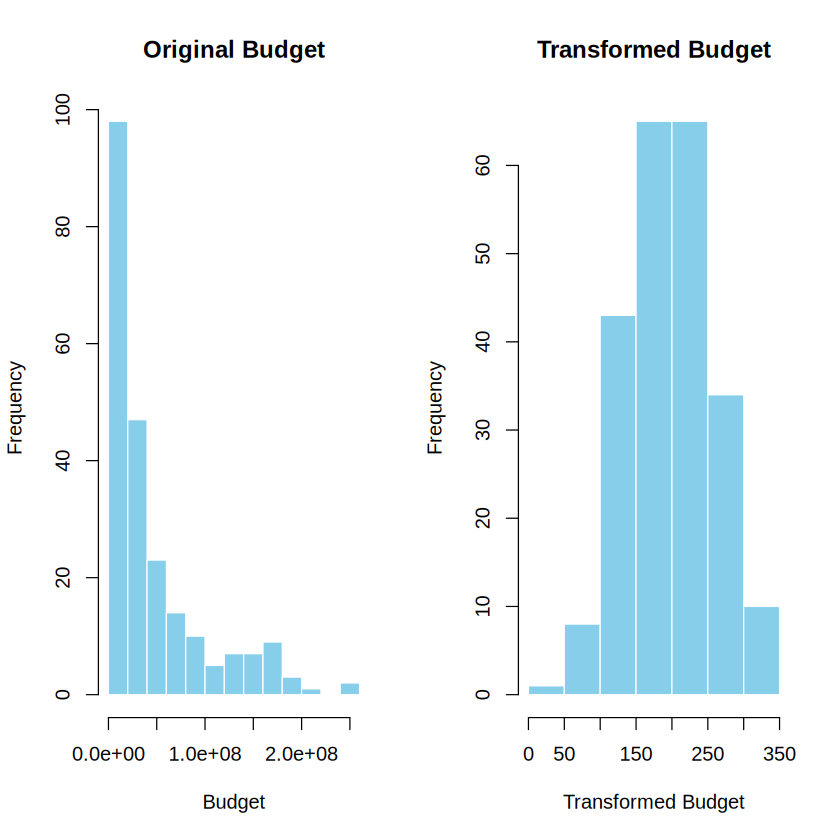

In [56]:
response_variable <- cleaned_df$Budget 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Budget", xlab = "Budget", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Budget", xlab = "Transformed Budget", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [57]:
cleaned_df$Budget <- transformed_response

### Phân tích biến `Screens`

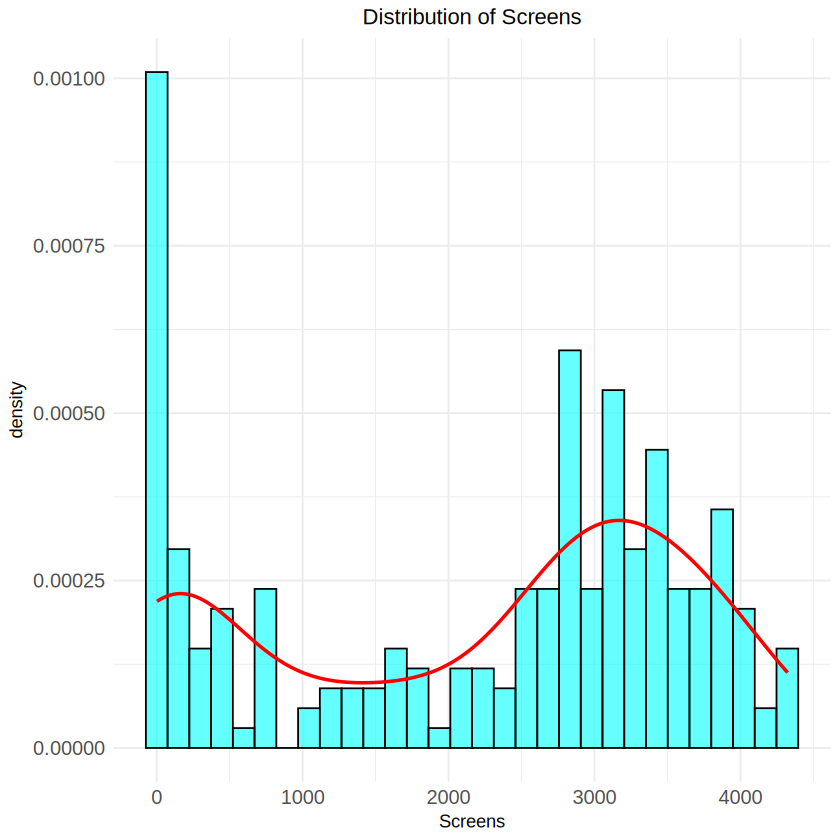

In [58]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Screens)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Screens") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.585858585858586"


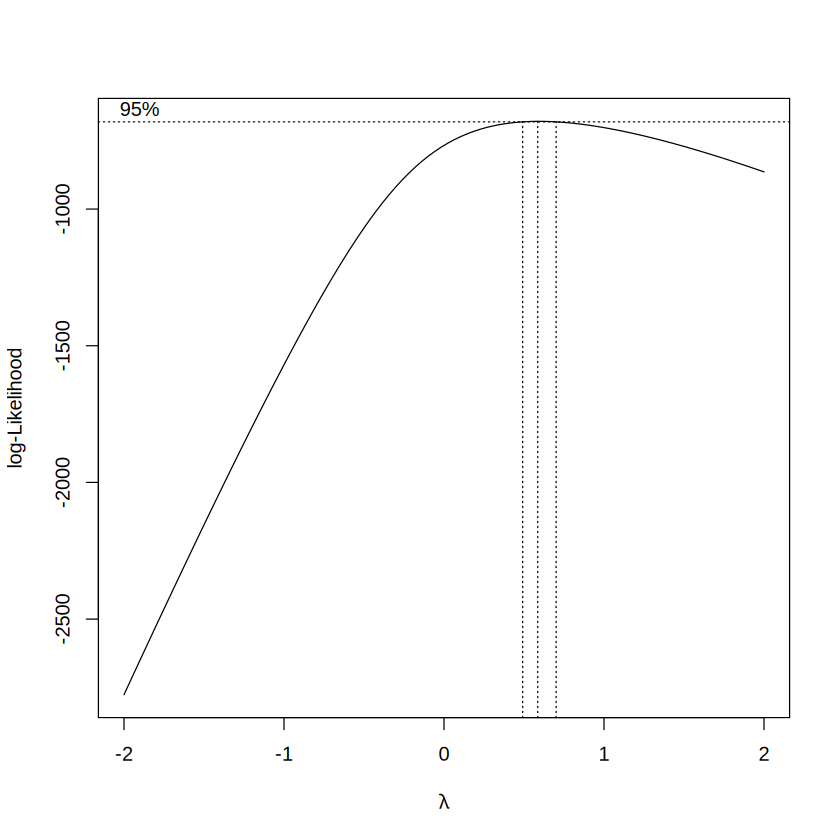

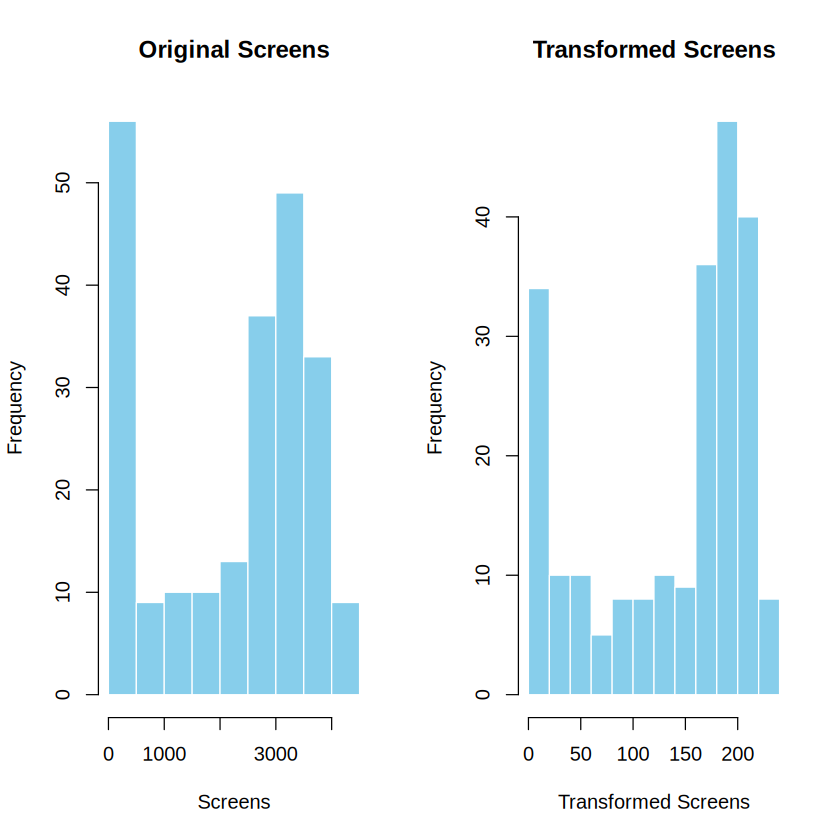

In [59]:
response_variable <- cleaned_df$Screens 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Screens", xlab = "Screens", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Screens", xlab = "Transformed Screens", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [60]:
cleaned_df$Screens <- transformed_response

### Phân tích biến `Sentiment`

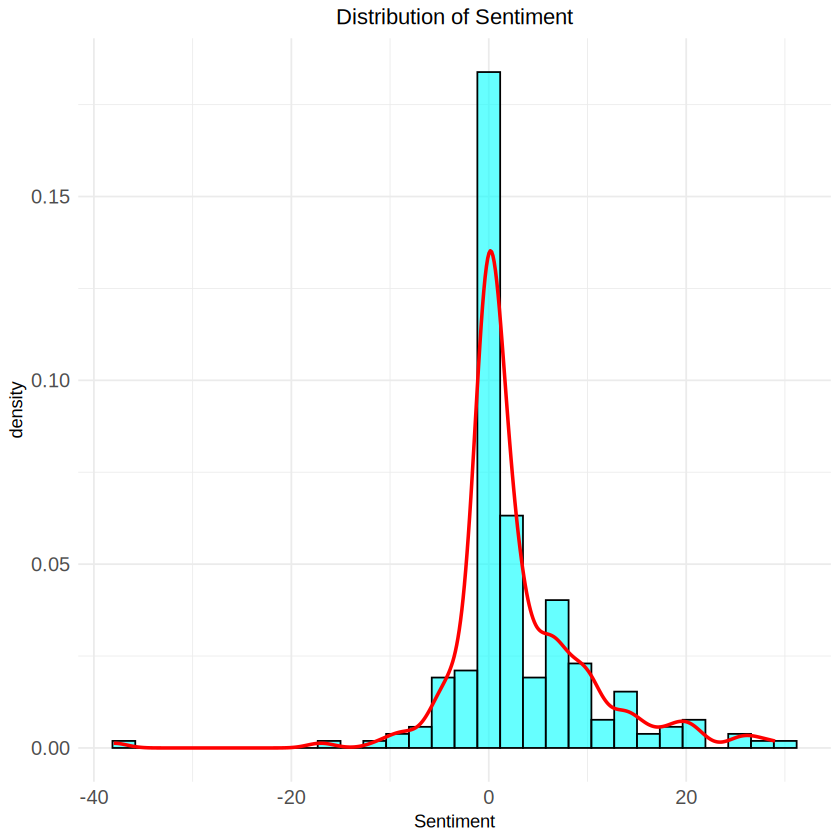

In [61]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Sentiment)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Sentiment") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

### Phân tích biến `Views`

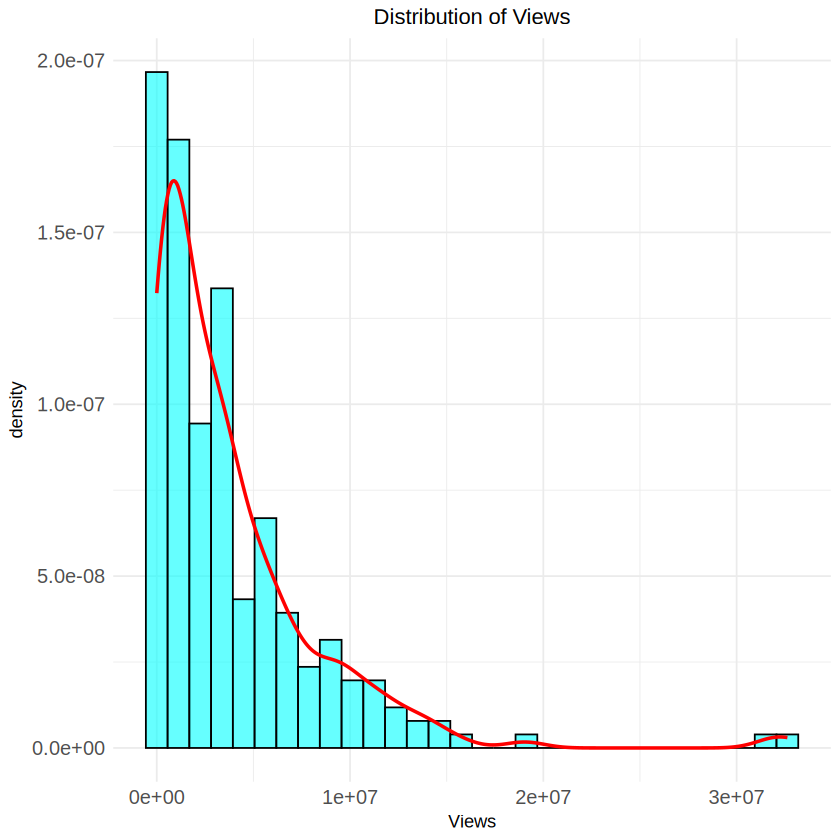

In [62]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Views)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Views") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.262626262626263"


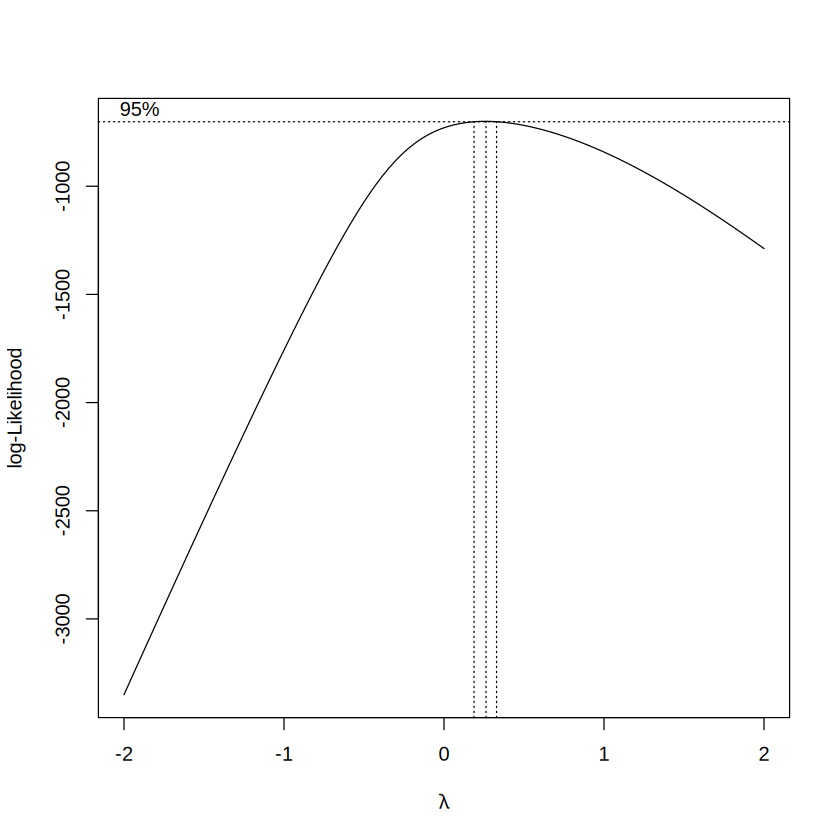

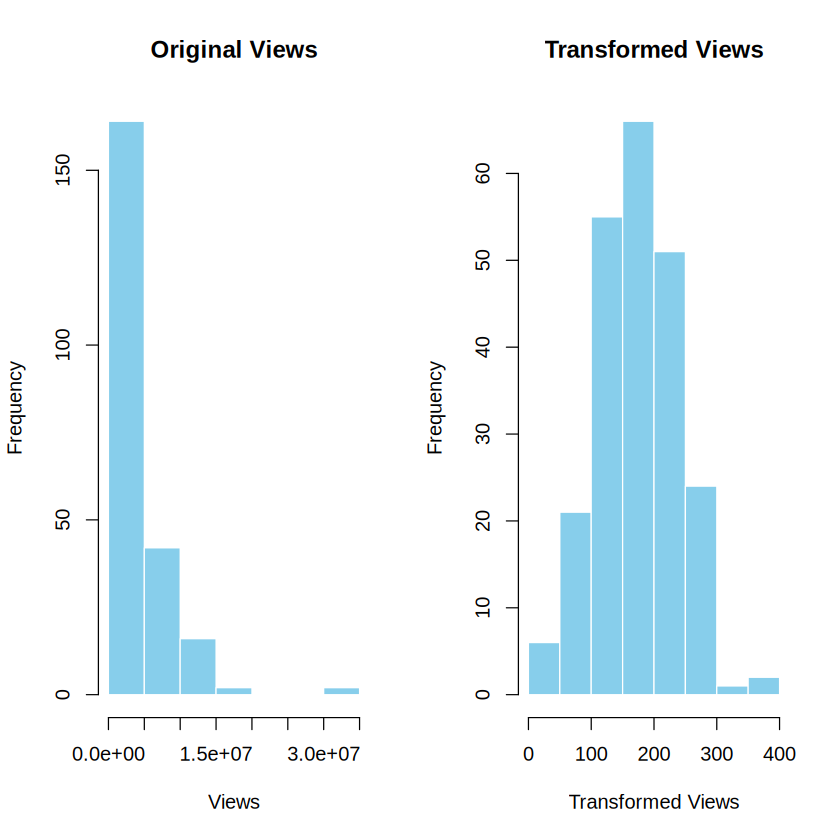

In [63]:
response_variable <- cleaned_df$Views 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Views", xlab = "Views", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Views", xlab = "Transformed Views", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [64]:
cleaned_df$Views <- transformed_response

### Phân tích biến `Likes`

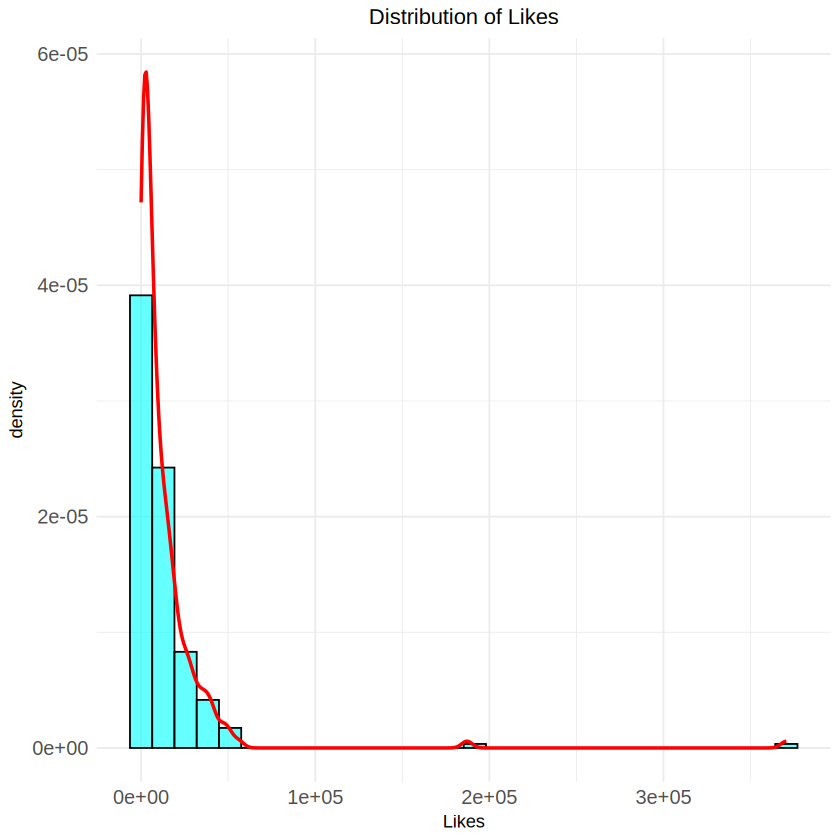

In [65]:
# tidy_empirical(train$Dislikes) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Likes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Likes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


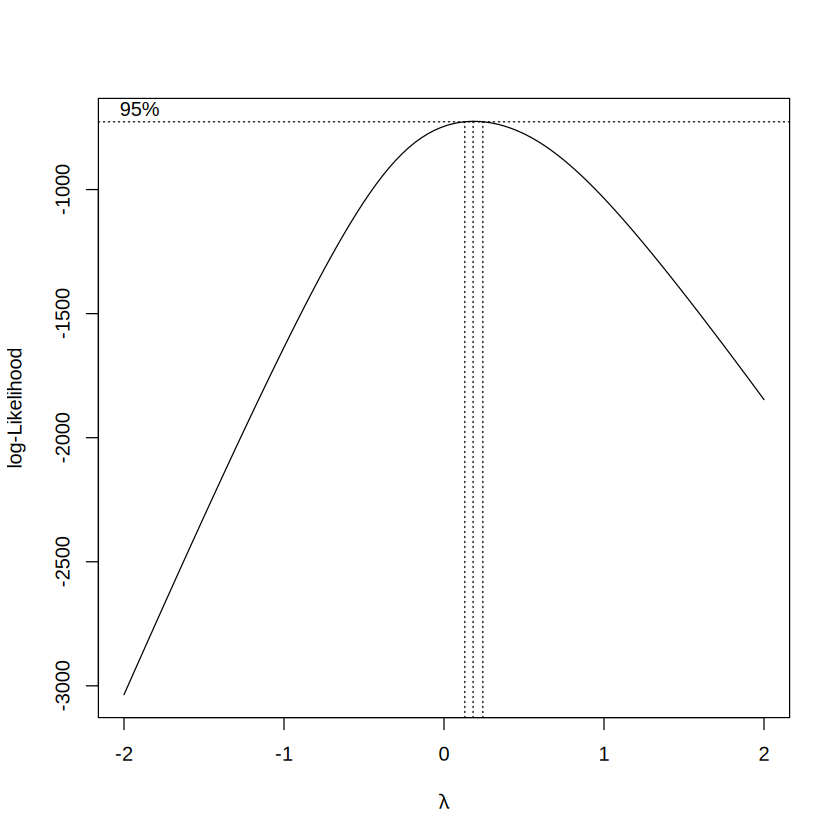

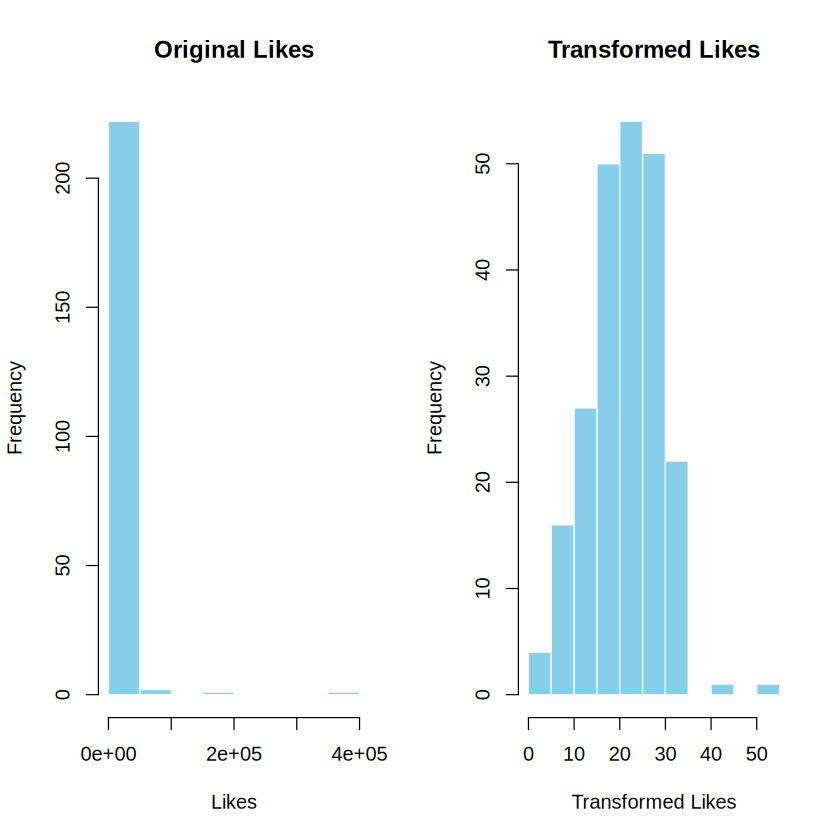

In [66]:
response_variable <- cleaned_df$Likes[cleaned_df$Likes != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Likes", xlab = "Likes", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Likes", xlab = "Transformed Likes", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

In [67]:
cleaned_df$Likes <- (cleaned_df$Likes^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `Dislikes`

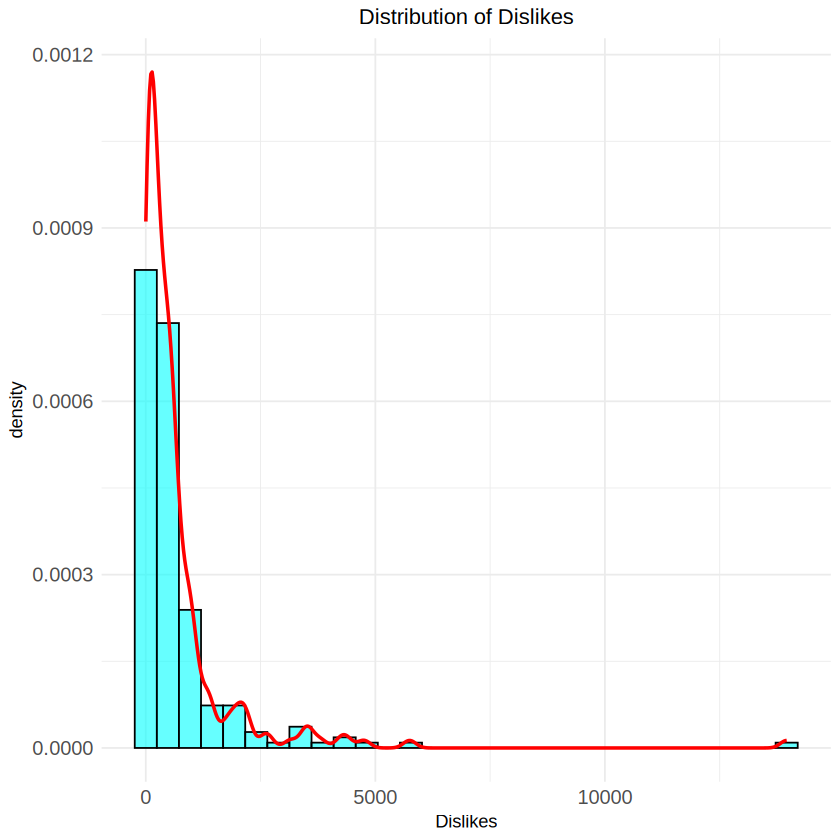

In [68]:
# tidy_empirical(train$Dislikes) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Dislikes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Dislikes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

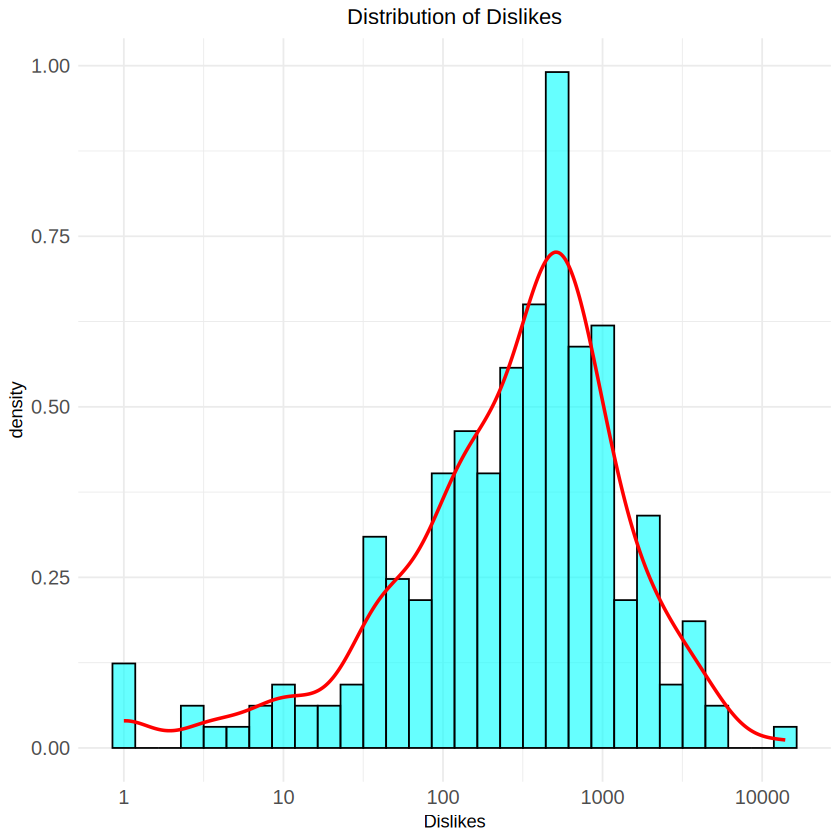

In [69]:
ggplot(cleaned_df, aes(x = Dislikes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of Dislikes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


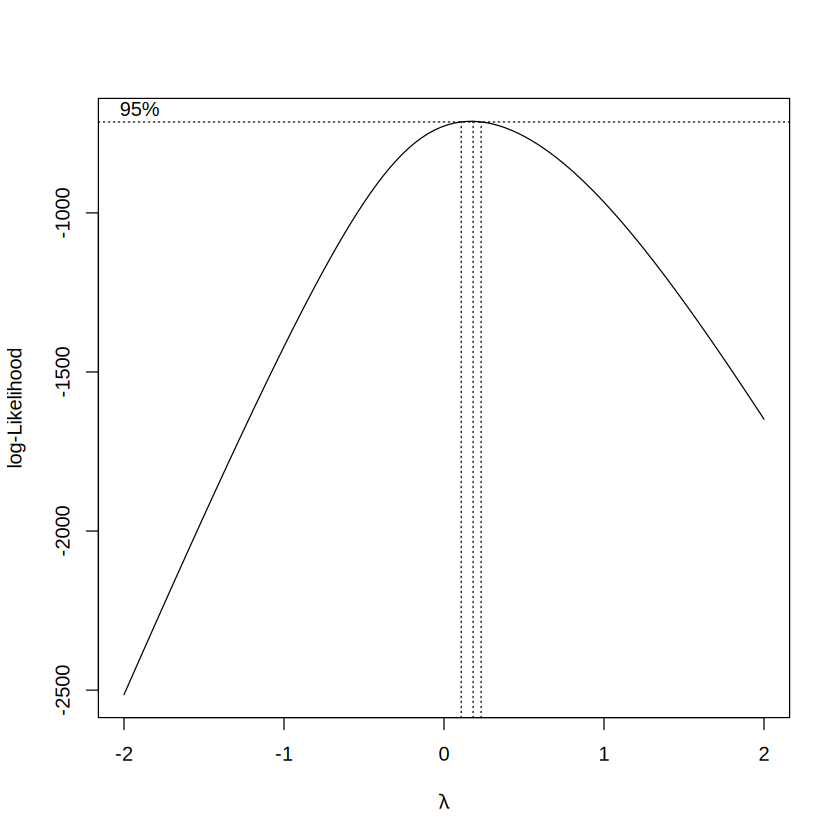

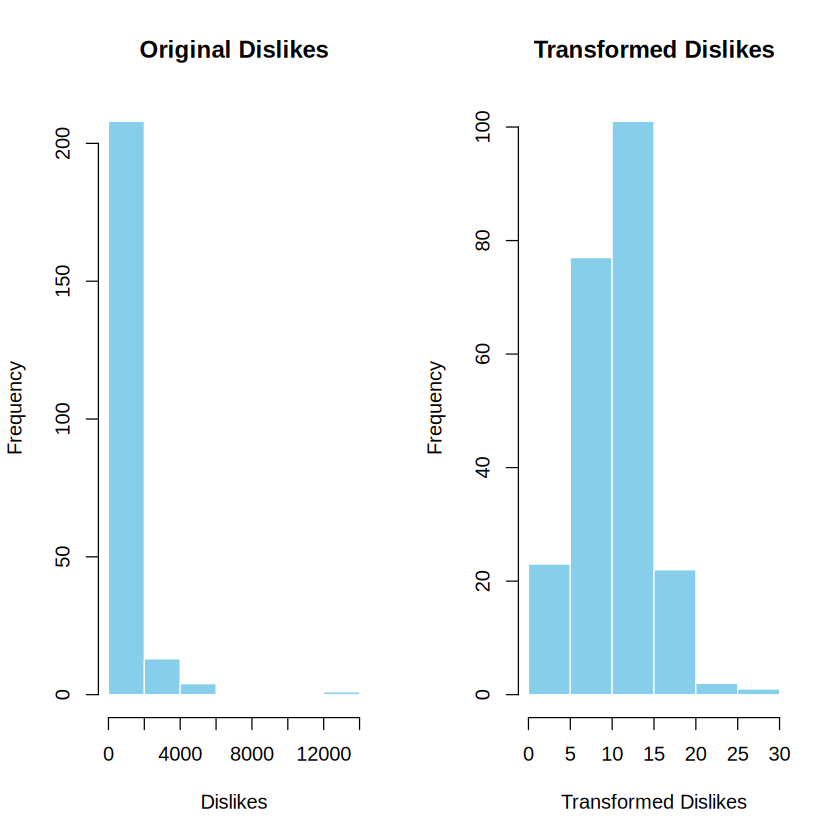

In [70]:
response_variable <- cleaned_df$Dislikes[cleaned_df$Dislikes != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Dislikes", xlab = "Dislikes", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Dislikes", xlab = "Transformed Dislikes", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `Dislikes` đã tương đối chuẩn hơn.

In [71]:
cleaned_df$Dislikes <- (cleaned_df$Dislikes^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `Comments`

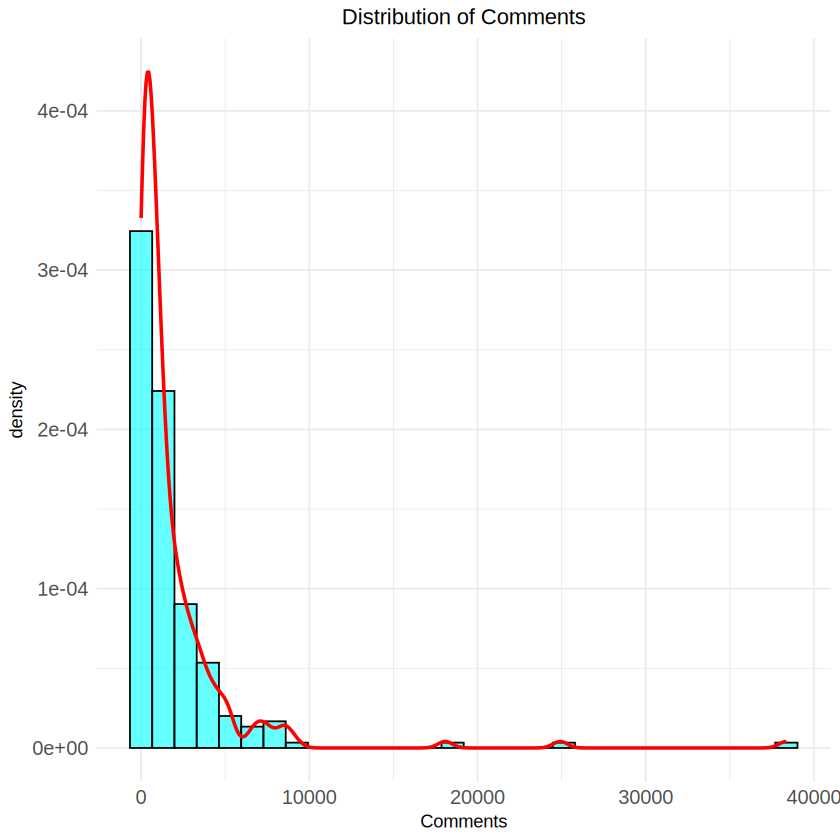

In [72]:
# tidy_empirical(train$Comments) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Comments)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Comments") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )


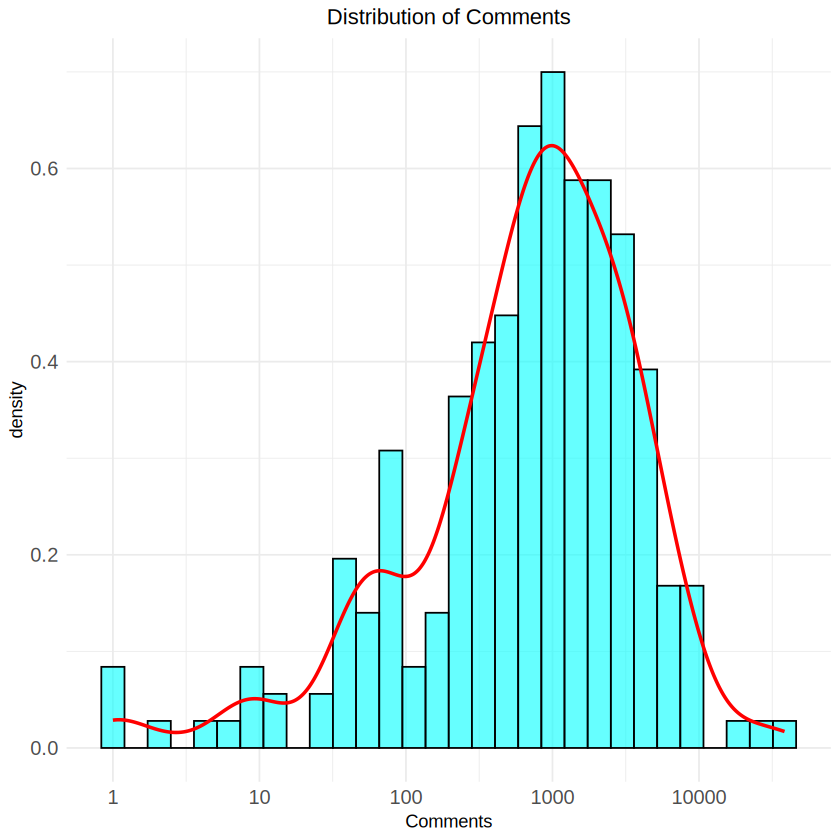

In [73]:
ggplot(cleaned_df, aes(x = Comments)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of Comments") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


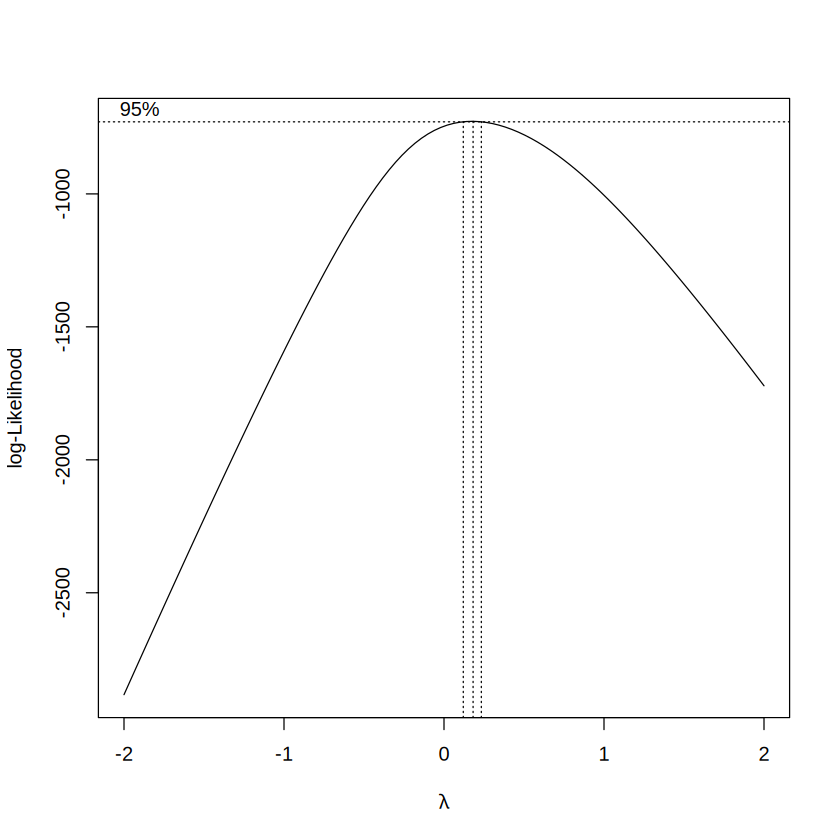

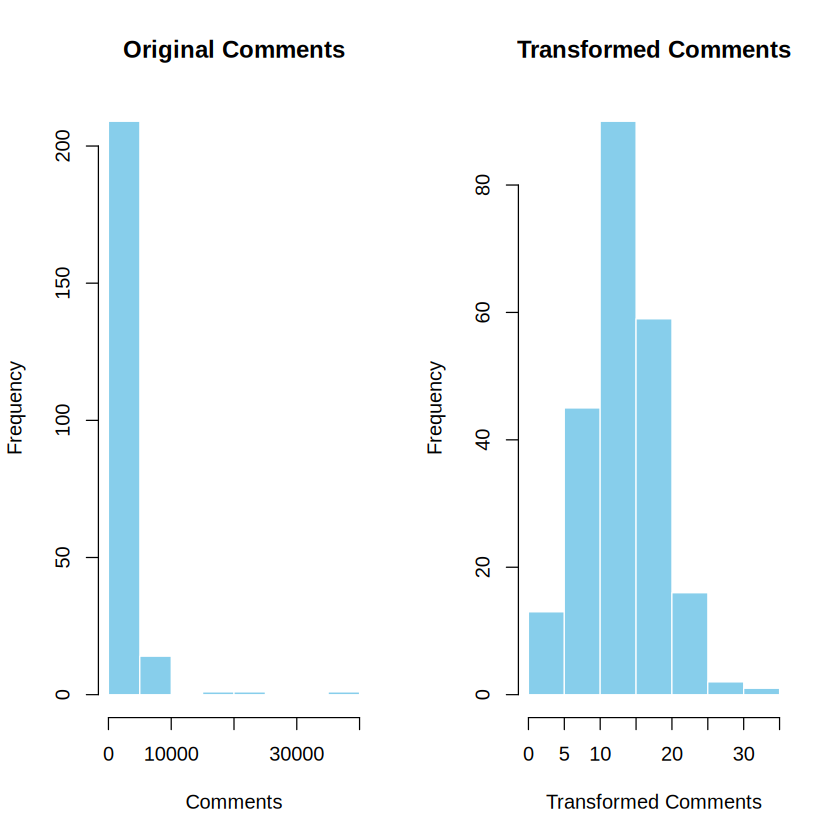

In [74]:
response_variable <- cleaned_df$Comments[cleaned_df$Comments != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Comments", xlab = "Comments", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Comments", xlab = "Transformed Comments", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `Comments` đã tương đối chuẩn hơn.

In [75]:
cleaned_df$Comments <- (cleaned_df$Comments^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `AggregateFollowers`

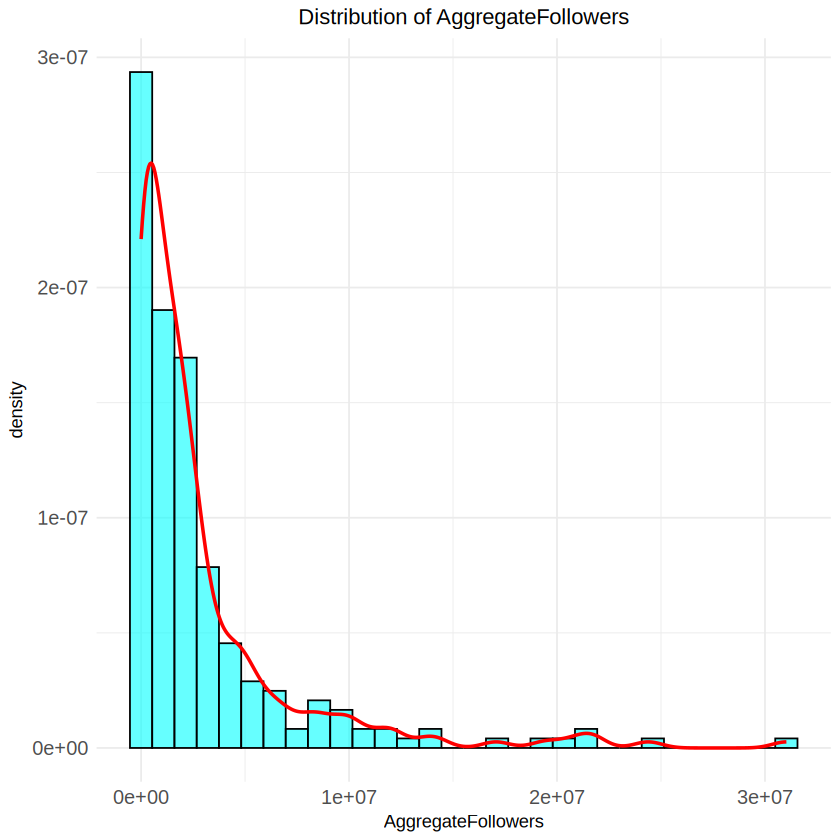

In [76]:
# tidy_empirical(train$AggregateFollowers) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

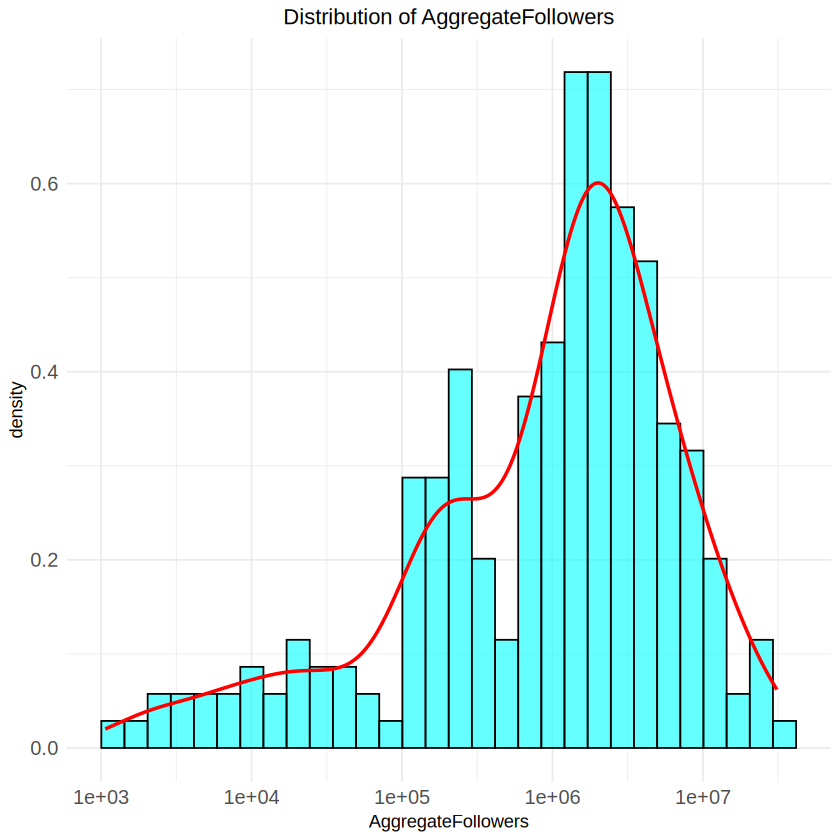

In [77]:
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


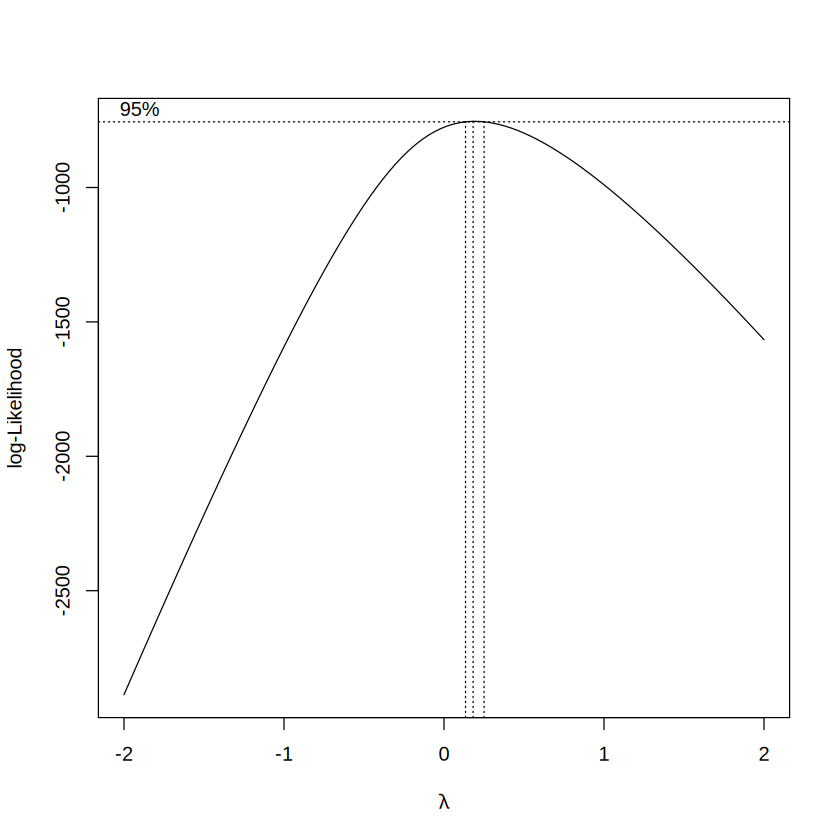

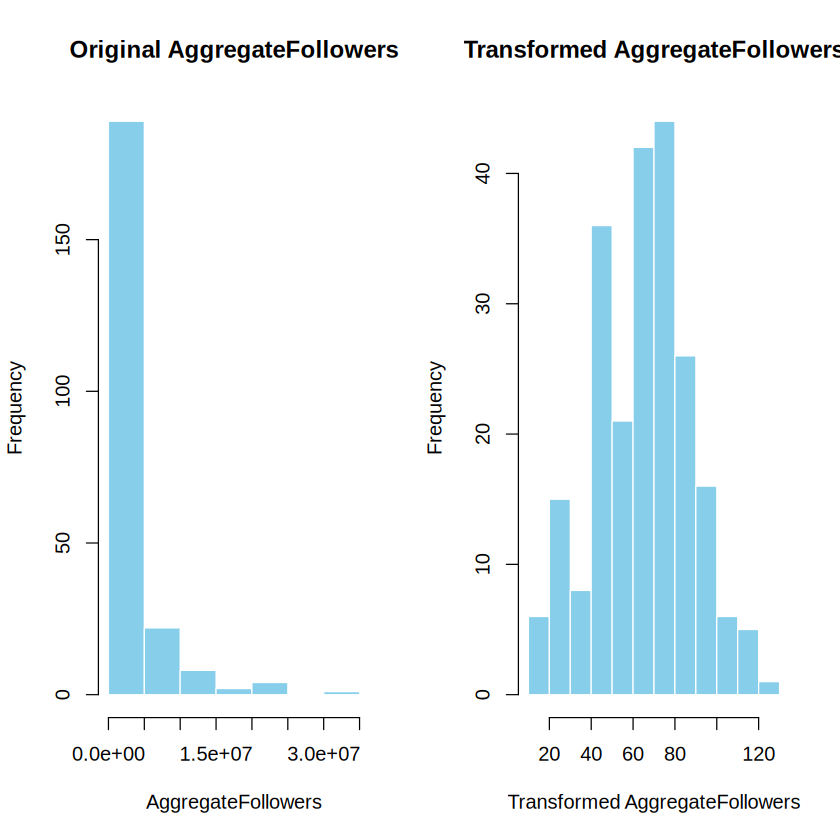

In [78]:
response_variable <- cleaned_df$AggregateFollowers
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original AggregateFollowers", xlab = "AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed AggregateFollowers", xlab = "Transformed AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `AggregateFollowers` đã tương đối chuẩn hơn.

In [79]:
cleaned_df$AggregateFollowers <- (cleaned_df$AggregateFollowers^optimal_lambda - 1) / optimal_lambda

## Phân chia tập dữ liệu

In [80]:
n = nrow(cleaned_df)
train_indices <- sample(seq_len(n), size = 0.7 * n)
train = cleaned_df[train_indices,]
test = cleaned_df[-train_indices,]

In [81]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 158  13

In [82]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 68 13

In [83]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	158 obs. of  13 variables:
 $ Year              : num  2015 2014 2015 2014 2014 ...
 $ Ratings           : num  15.9 13.2 16.7 13.9 19.2 ...
 $ Genre             : num  1 3 3 3 1 12 1 1 1 8 ...
 $ Gross             : num  351 323 367 165 614 ...
 $ Budget            : num  226 265 208 145 299 ...
 $ Screens           : num  191 200 197 62 216 ...
 $ Sequel            : num  1 1 1 1 2 2 1 2 1 1 ...
 $ Sentiment         : num  8 0 19 2 5 3 0 0 7 0 ...
 $ Views             : num  239 284 176 208 130 ...
 $ Likes             : num  28.8 31.7 25.4 23.4 18 ...
 $ Dislikes          : num  12.98 15.18 10.61 11.23 6.28 ...
 $ Comments          : num  18.7 21.9 12 14.3 13.2 ...
 $ AggregateFollowers: num  79.7 21.2 49.8 84.6 93.5 ...


## Mô hình hóa

### Khảo sát sự tương quan giữa các biến

In [84]:
round(cor(train[, c(1:13)]), 2)

,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
Year,1.00,0.04,-0.04,0.16,0.13,0.21,0.09,0.23,0.18,0.21,0.24,0.10,-0.04
Ratings,0.04,1.00,-0.09,0.29,0.25,0.06,0.09,0.15,0.06,0.11,-0.13,0.07,0.17
Genre,-0.04,-0.09,1.00,-0.17,-0.33,-0.19,-0.22,-0.12,-0.03,-0.06,-0.05,-0.09,-0.08
Gross,0.16,0.29,-0.17,1.00,0.71,0.74,0.31,0.05,0.28,0.36,0.36,0.34,0.21
Budget,0.13,0.25,-0.33,0.71,1.00,0.65,0.33,0.10,0.25,0.28,0.29,0.28,0.25
Screens,0.21,0.06,-0.19,0.74,0.65,1.00,0.27,-0.01,0.30,0.39,0.38,0.37,0.13
Sequel,0.09,0.09,-0.22,0.31,0.33,0.27,1.00,-0.05,0.00,0.01,-0.01,-0.02,0.14
Sentiment,0.23,0.15,-0.12,0.05,0.10,-0.01,-0.05,1.00,0.07,0.09,0.04,0.10,0.07
Views,0.18,0.06,-0.03,0.28,0.25,0.30,0.00,0.07,1.00,0.92,0.89,0.87,0.20
Likes,0.21,0.11,-0.06,0.36,0.28,0.39,0.01,0.09,0.92,1.00,0.88,0.93,0.20


Một số nhận xét:
- Biến `Ratings` và biến `AggregateFollowers` có tương quan với biến `Gross` cao, lần lượt 0.38 và 0.26
- Các biến `Dislikes` và `Comments` có tương quan với biến `Gross` thấp hơn hai biến còn lại, 0.20
- Biến `Comments` có tương quan cao với biến `Dislikes`, 0.89
- Biến `Comments` có tương quan nghịch với biến `Ratings`, -0.12

### Xây dựng mô hình đầy đủ

In [85]:
str(train)

'data.frame':	158 obs. of  13 variables:
 $ Year              : num  2015 2014 2015 2014 2014 ...
 $ Ratings           : num  15.9 13.2 16.7 13.9 19.2 ...
 $ Genre             : num  1 3 3 3 1 12 1 1 1 8 ...
 $ Gross             : num  351 323 367 165 614 ...
 $ Budget            : num  226 265 208 145 299 ...
 $ Screens           : num  191 200 197 62 216 ...
 $ Sequel            : num  1 1 1 1 2 2 1 2 1 1 ...
 $ Sentiment         : num  8 0 19 2 5 3 0 0 7 0 ...
 $ Views             : num  239 284 176 208 130 ...
 $ Likes             : num  28.8 31.7 25.4 23.4 18 ...
 $ Dislikes          : num  12.98 15.18 10.61 11.23 6.28 ...
 $ Comments          : num  18.7 21.9 12 14.3 13.2 ...
 $ AggregateFollowers: num  79.7 21.2 49.8 84.6 93.5 ...


In [86]:
full.lm <- lm(Gross ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = Gross ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-334.16  -54.80   -2.68   51.41  243.97 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        24326.2146 36872.6193   0.660  0.51047    
Year                 -12.1591    18.3084  -0.664  0.50766    
Ratings               10.6108     2.4009   4.419 1.93e-05 ***
Genre                  2.6733     1.9025   1.405  0.16212    
Budget                 0.8130     0.1807   4.500 1.39e-05 ***
Screens                1.0163     0.1478   6.877 1.69e-10 ***
Sequel                15.7181     9.2349   1.702  0.09089 .  
Sentiment              0.1785     1.1193   0.160  0.87350    
Views                 -0.7413     0.3408  -2.175  0.03121 *  
Likes                  0.6786     3.5400   0.192  0.84825    
Dislikes              14.3898     4.7365   3.038  0.00282 ** 
Comments              -1.1382     4.0108  -0.284  0.77698    
AggregateFollowers     0.1135     0.3584

### Lựa chọn model tốt nhất

Với số lượng lớn các yếu tố dự đoán, điều quan trọng là phải giảm thiểu mô hình bằng cách chỉ bao gồm các yếu tố dự đoán hữu ích. Có tất cả 6 yếu tố dự đoán trong tập dữ liệu, nghĩ là có thể có $2^{12}$ mô hình hồi quy. Để chọn mô hình một cách hiệu quả, việc lựa chọn lùi được thực hiện bằng sử dụng step function. Phương pháp này lặp lại các quy trình để giảm thiểu Akaike’s Information Criteria (AIC) và Bayesian Information Criteria (BIC). Lựa chọn mô hình ngược so với lựa chọn tiến vì nó loại bỏ khả năng một yếu tố dự đoán mới được chọn có khả năng tương tự hoặc nhiều hơn để giải thích các phần của phản hồi đã được giải thích bởi một yếu tố dự đoán khác có trong mô hình.

In [87]:
# Model lower bound
model.lb <- lm(Gross ~ 1, data = train) 

In [88]:
# Model upper bound
model.up <- full.lm

In [126]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = Gross ~ Ratings + Genre + Budget + Screens + Sequel + 
    Views + Dislikes, data = train)

Coefficients:
(Intercept)      Ratings        Genre       Budget      Screens       Sequel  
  -157.3226      10.5466       2.7155       0.8284       1.0028      15.7288  
      Views     Dislikes  
    -0.7049      13.5588  


In [127]:
csm_models<- regsubsets(Gross ~  Ratings + Genre + Budget + Screens + Sequel + Views + Dislikes, data = train)
summary.csm<-summary(csm_models)

In [128]:
#picking the best regression model using reg subsets 
summary.csm$which

,(Intercept),Ratings,Genre,Budget,Screens,Sequel,Views,Dislikes
1,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
3,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
4,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE
5,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE
6,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE
7,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [129]:
#Criteria
# model with largest increase in R^2 (equivalent to smallest MSE)
summary.csm$rsq

[1] 0.5455729 0.6390676 0.6671302 0.6757668 0.6888253 0.6938969 0.6982170

In [130]:
# model with largest adjusted R^2 
summary.csm$adjr2

[1] 0.5426599 0.6344104 0.6606457 0.6672902 0.6785893 0.6817339 0.6841338

In [131]:
# model with smallest Mallow's Cp
summary.csm$cp

[1] 71.871139 27.400014 15.451581 13.158786  8.668134  8.147288  8.000000

#### Chọn mô hình tốt nhất dựa trên BIC

In [132]:
# model with lowest bic
summary.csm$bic

[1] -114.4922 -145.8244 -153.5502 -152.6412 -154.0737 -151.6075 -148.7907

In [133]:
best_model_index <- which.min(summary.csm$bic)
best_model <- summary.csm$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

(Intercept)     Ratings       Genre      Budget     Screens      Sequel 
       TRUE        TRUE       FALSE        TRUE        TRUE       FALSE 
      Views    Dislikes 
       TRUE        TRUE 
[1] "Ratings"  "Budget"   "Screens"  "Views"    "Dislikes"


In [134]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("Gross ~", paste(best_vars, collapse = " + "))
best_model_csm <- lm(as.formula(formula_str), data=train)

In [135]:
# Tóm tắt mô hình
summary(best_model_csm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-344.85  -56.89    1.79   51.49  243.91 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -122.1864    36.2243  -3.373 0.000943 ***
Ratings       10.4108     2.2271   4.675 6.45e-06 ***
Budget         0.8301     0.1642   5.057 1.21e-06 ***
Screens        1.0321     0.1381   7.472 5.80e-12 ***
Views         -0.6779     0.2684  -2.526 0.012574 *  
Dislikes      12.8582     4.0495   3.175 0.001813 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 92.48 on 152 degrees of freedom
Multiple R-squared:  0.6888,	Adjusted R-squared:  0.6786 
F-statistic: 67.29 on 5 and 152 DF,  p-value: < 2.2e-16


Như vậy, ta thu được mô hình

```
Gross ~ -122.1864 (Intercept) + 10.4108 * Ratings + 0.8301 * Budget + 1.0321 * Screens -0.6779 * Views + 12.8582 * Dislikes
```

Điều này có ý nghĩa là, biến `Gross` sẽ được giải thích thông qua hai biến `Ratings` và `Dislikes` 
- Điểm xếp hạng càng cao thì doanh thu của một bộ phim cũng cao (hợp lý theo logic thông thường).
- Số lượt chê càng cao thì doanh thu của một bộ phim cũng cao. Điều này có thể lý giải, khi một bộ phim có nhiều bình luận tiêu cực, người ta sẽ có hứng thú đi xem nó để biết tại sao nó bị chê (yếu tố tò mò).

Với mức ý nghĩa 0.05, ta lựa chọn các biến `Ratings`, `Budget`, và `Screens`

In [136]:
# Lựa chọn các biến
best_model_csm.2 <- lm(Gross ~ Ratings + Budget + Screens, data=train)

# Tóm tắt mô hình
summary(best_model_csm.2)


Call:
lm(formula = Gross ~ Ratings + Budget + Screens, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-372.33  -50.92   -6.22   57.56  273.49 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -91.9193    33.6547  -2.731 0.007046 ** 
Ratings       7.4974     2.0808   3.603 0.000424 ***
Budget        0.8894     0.1674   5.312 3.73e-07 ***
Screens       1.1336     0.1370   8.276 5.65e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 95.02 on 154 degrees of freedom
Multiple R-squared:  0.6671,	Adjusted R-squared:  0.6606 
F-statistic: 102.9 on 3 and 154 DF,  p-value: < 2.2e-16


Bây giờ, ta sẽ đi phân tích xem mô hình này có thỏa những giả định của mô hình hồi quy bội hay không?

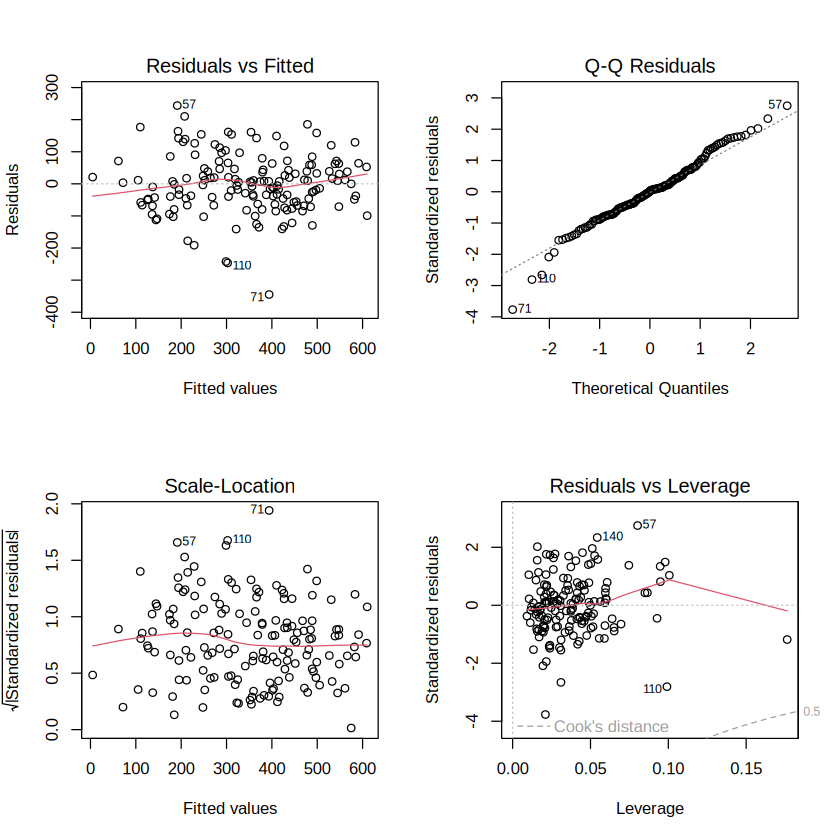

In [140]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_csm)

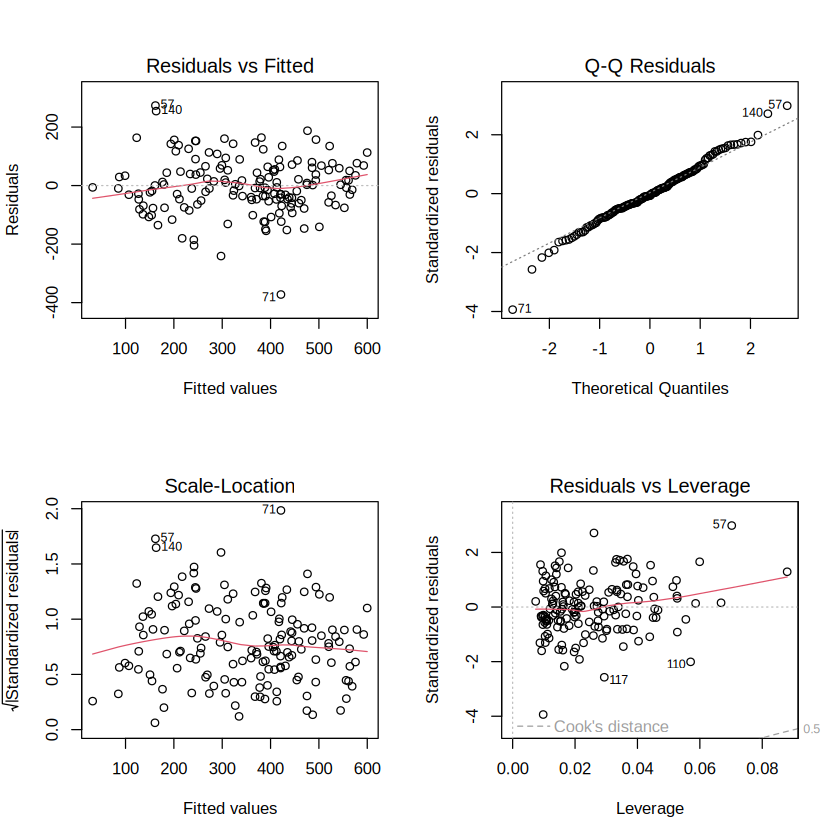

In [137]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_csm.2)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

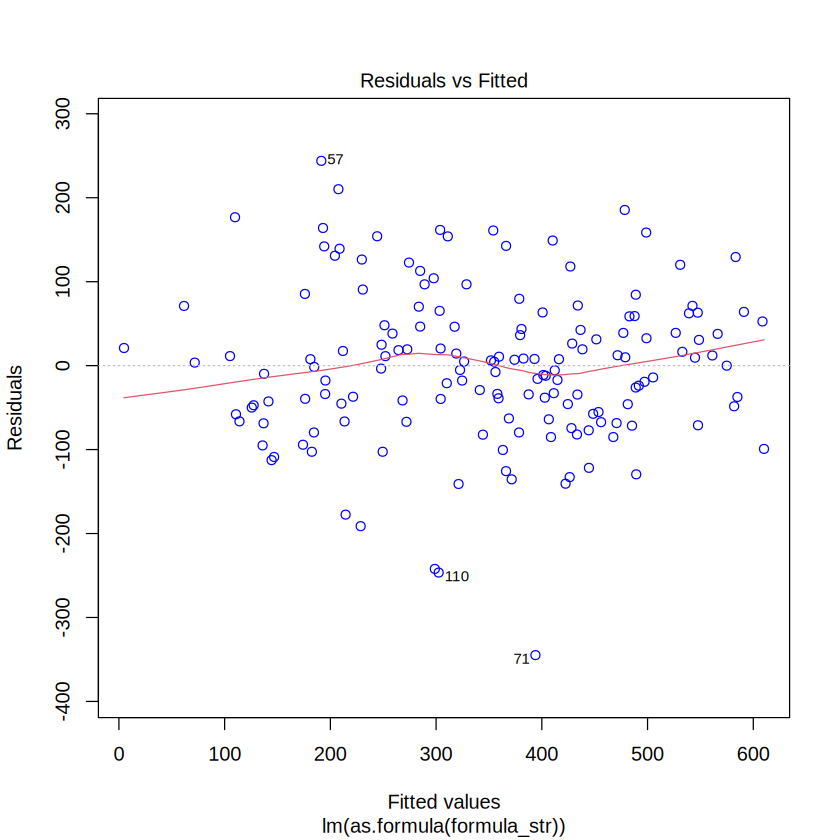

In [141]:
plot(best_model_csm, which=1, col=c("blue")) # Residuals vs Fitted Plot

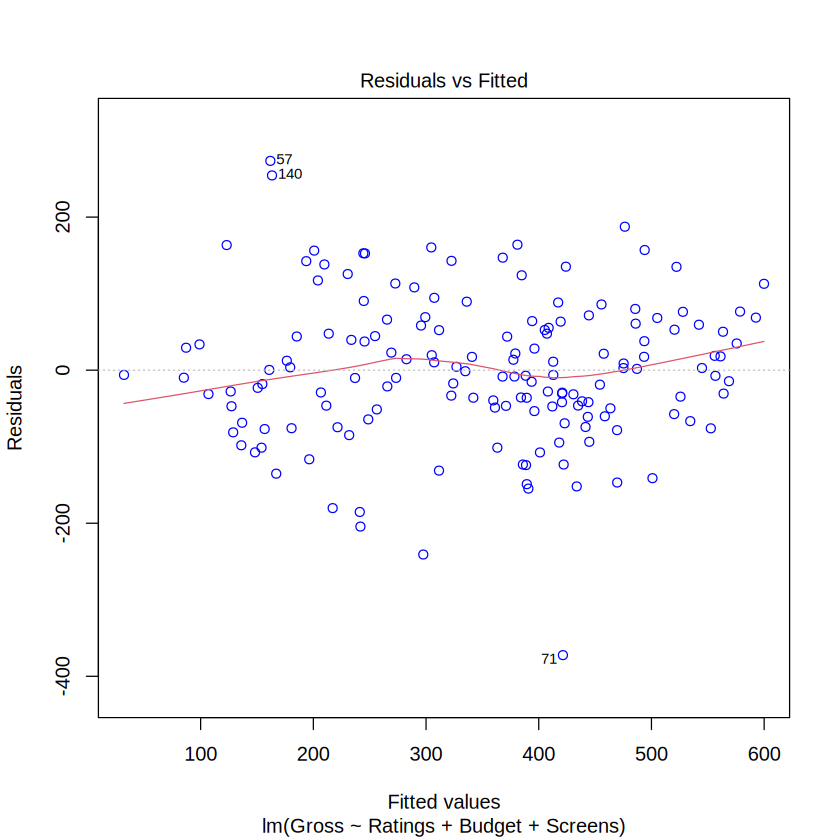

In [138]:
plot(best_model_csm.2, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

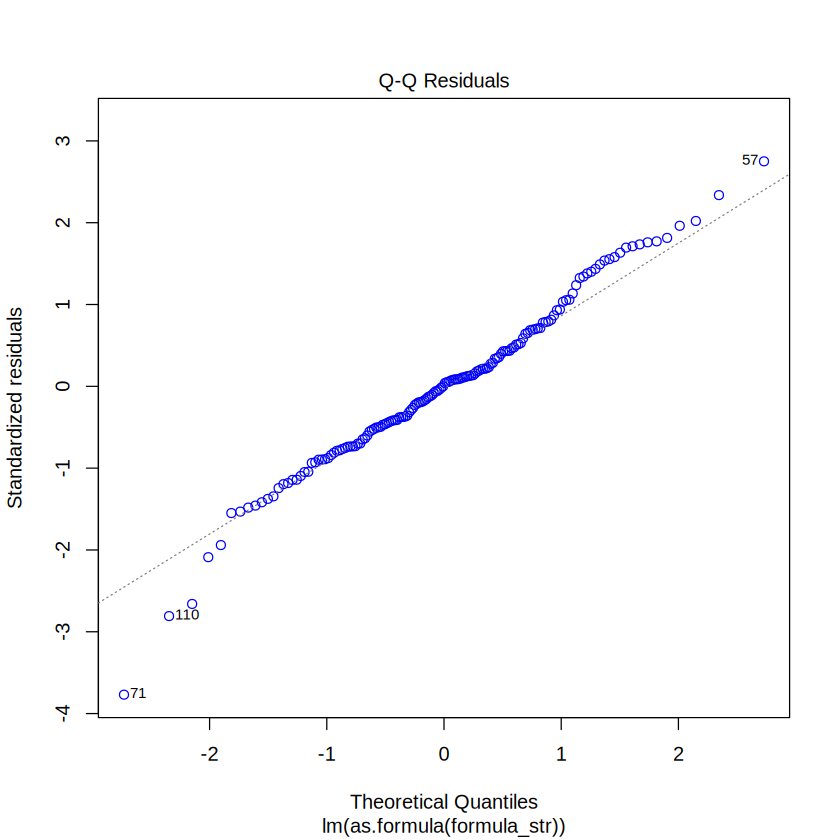

In [142]:
plot(best_model_csm, which=2, col=c("blue")) # QQ Plot

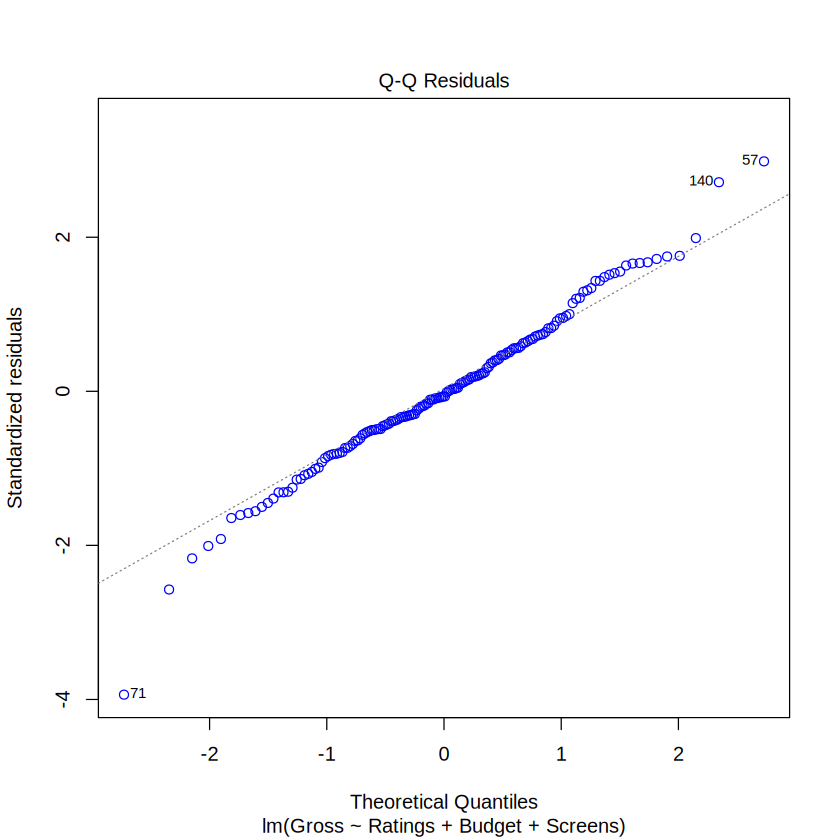

In [143]:
plot(best_model_csm.2, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [144]:
# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm))


	Shapiro-Wilk normality test

data:  residuals(best_model_csm)
W = 0.98303, p-value = 0.04968


In [145]:
# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.2)) # Thặng dư không chuẩn


	Shapiro-Wilk normality test

data:  residuals(best_model_csm.2)
W = 0.98568, p-value = 0.1036


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

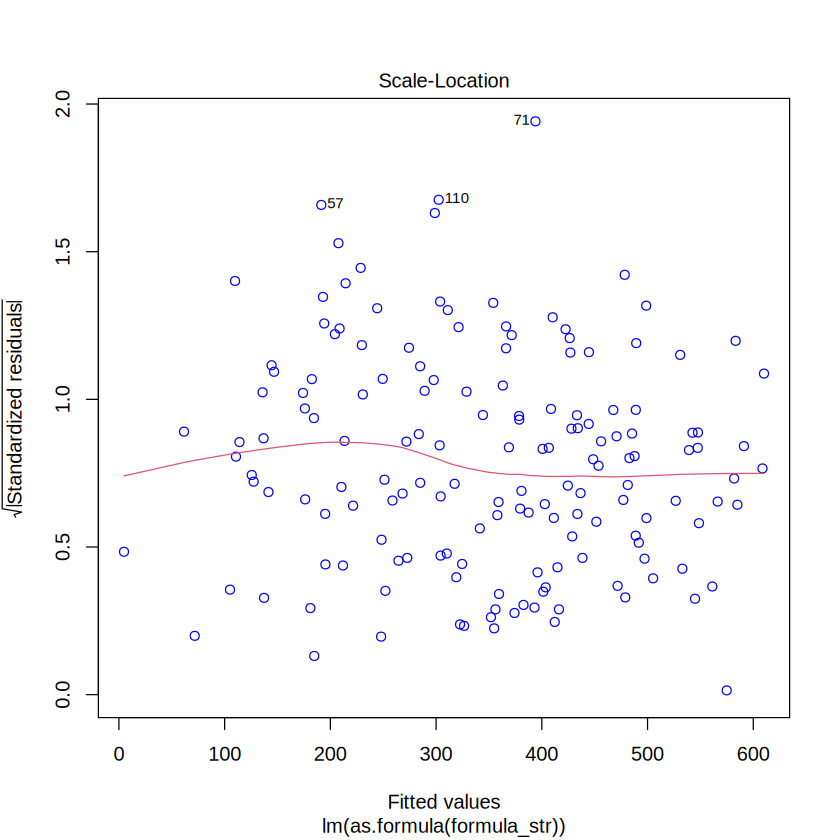

In [146]:
plot(best_model_csm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [147]:
# Breusch-Pagan Test
bptest(best_model_csm)


	studentized Breusch-Pagan test

data:  best_model_csm
BP = 3.0681, df = 5, p-value = 0.6895


Như vậy, ta thấy p-value lớn hơn múc ý nghĩa 0.05 rất nhiều, ta đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là heteroscedastic

In [148]:
# Breusch-Pagan Test
bptest(best_model_csm.2) # Tương tự như kết luận trên


	studentized Breusch-Pagan test

data:  best_model_csm.2
BP = 3.1635, df = 3, p-value = 0.3671


#### Phân tích Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

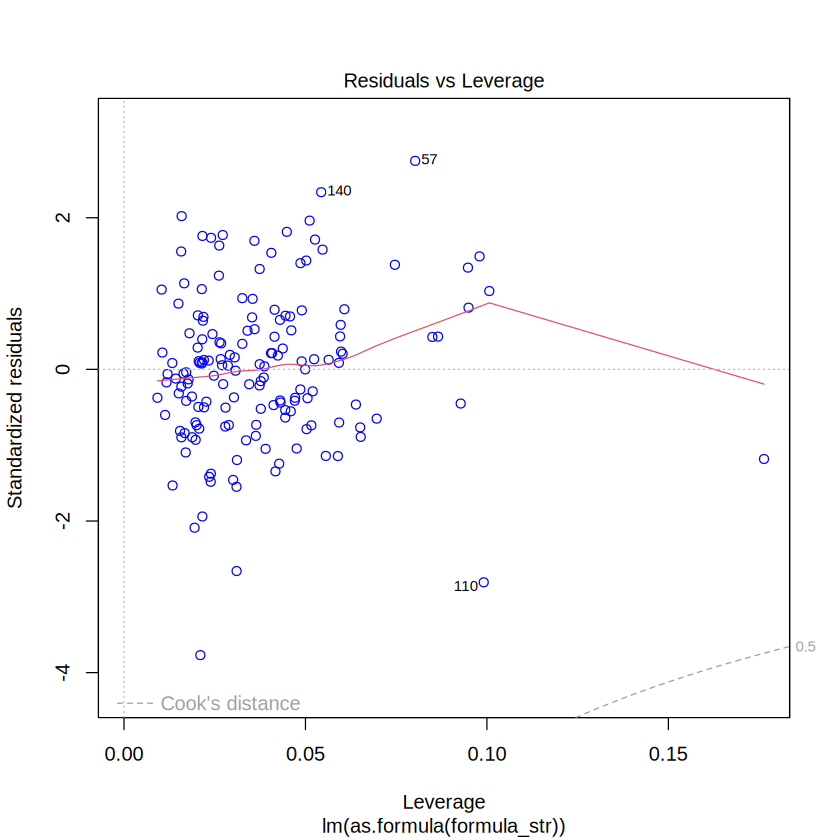

In [149]:
plot(best_model_csm, which=5, col=c("blue")) # Residuals vs Leverage

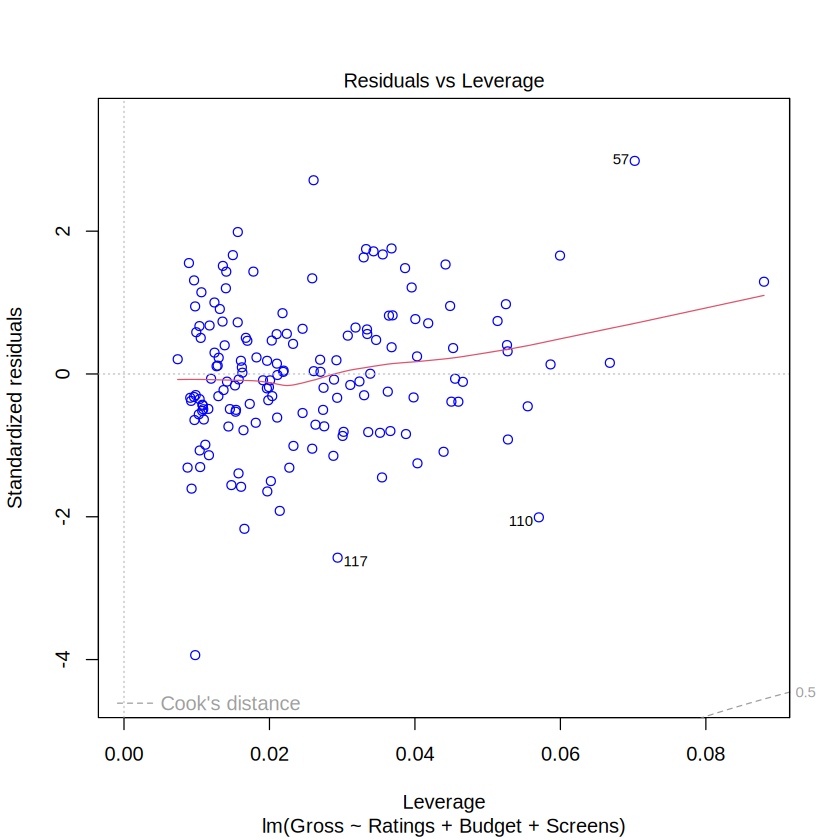

In [150]:
plot(best_model_csm.2, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

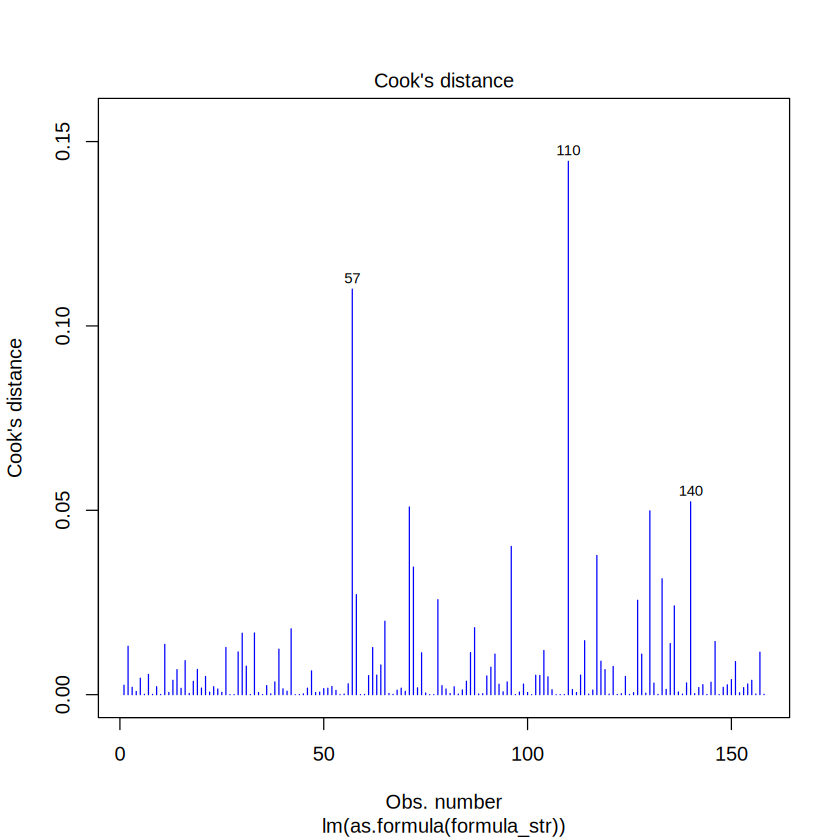

In [151]:
plot(best_model_csm, which=4, col=c("blue"))

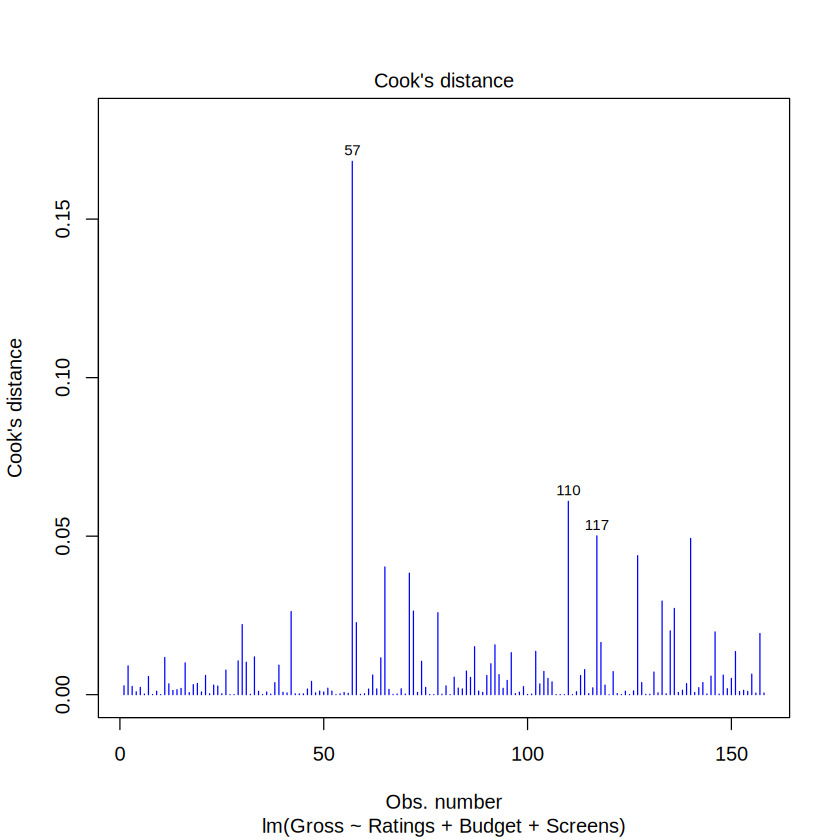

In [152]:
plot(best_model_csm.2, which=4, col=c("blue"))

Kết luận:
- Mô hình thu được có thể được sử dụng để đem đi dự đoán.

### Loại bỏ ngoại lai dựa trên Cook'Distance

In [159]:
best_model_csm.3 <- lm(as.formula(formula_str), data=train[-c(57, 110, 117), ])
summary(best_model_csm.3)


Call:
lm(formula = as.formula(formula_str), data = train[-c(57, 110, 
    117), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-340.60  -54.10   -5.16   45.30  199.82 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -120.9100    33.9257  -3.564 0.000491 ***
Ratings       12.3065     2.1071   5.840 3.15e-08 ***
Budget         0.5926     0.1598   3.707 0.000295 ***
Screens        1.1852     0.1327   8.932 1.46e-15 ***
Views         -0.7635     0.2530  -3.018 0.002994 ** 
Dislikes      14.2717     3.8595   3.698 0.000305 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 85.99 on 149 degrees of freedom
Multiple R-squared:  0.7244,	Adjusted R-squared:  0.7151 
F-statistic: 78.32 on 5 and 149 DF,  p-value: < 2.2e-16


In [160]:
# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.3))


	Shapiro-Wilk normality test

data:  residuals(best_model_csm.3)
W = 0.97407, p-value = 0.005061


In [161]:
# Breusch-Pagan Test
bptest(best_model_csm.3)


	studentized Breusch-Pagan test

data:  best_model_csm.3
BP = 2.3132, df = 5, p-value = 0.8043


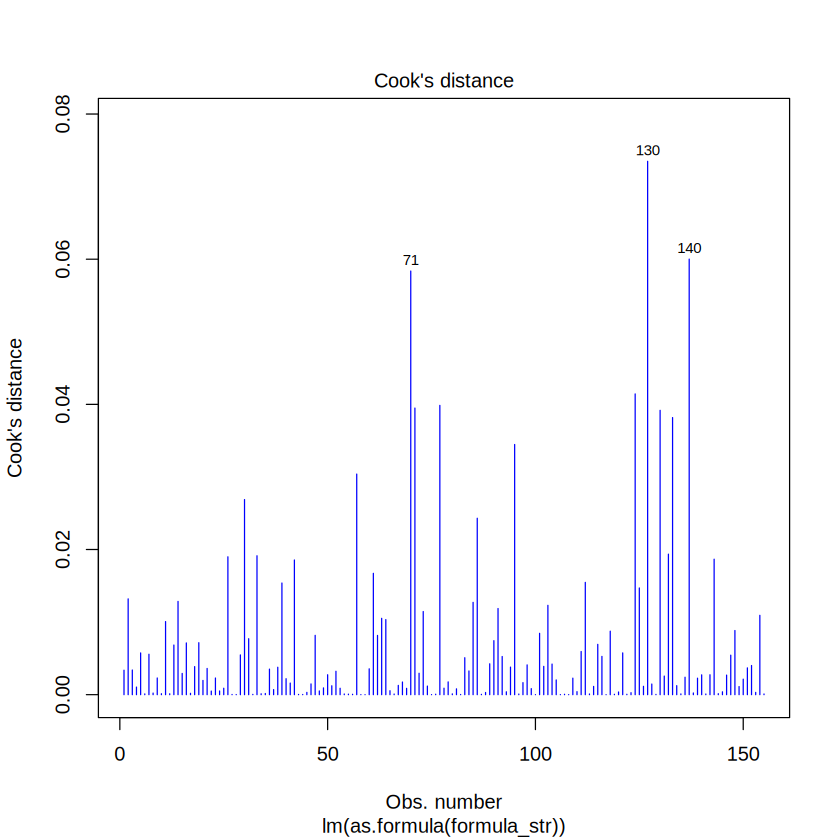

In [162]:
plot(best_model_csm.3, which=4, col=c("blue"))

### Dự đoán và đánh giá kết quả

[1] 100.0973

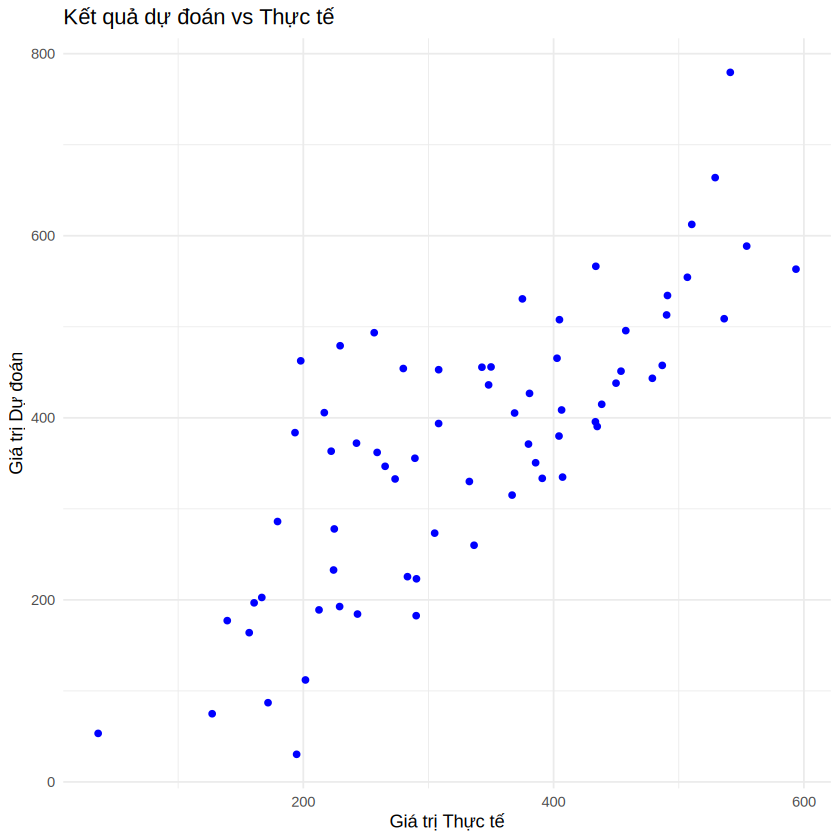

In [170]:
# predict
results <- predict(best_model_csm, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 97.54783

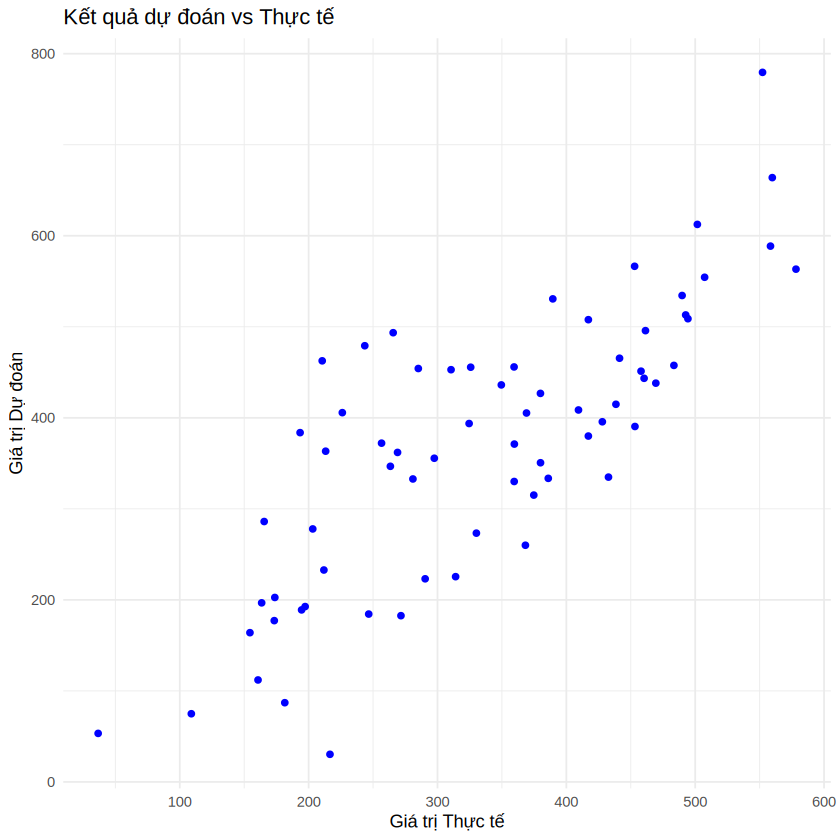

In [171]:
# predict
results <- predict(best_model_csm.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 105.3085

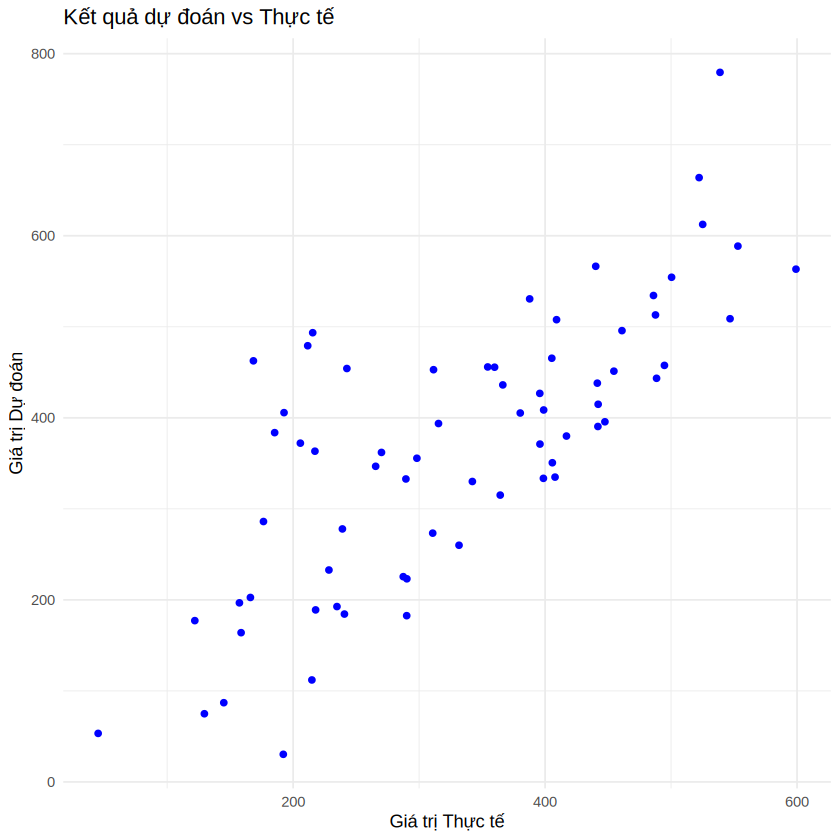

In [188]:
# predict
results <- predict(best_model_csm.3, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

## Khảo sát sự tương tác giữa các biến

Ở đây, chúng ta quan tâm đến biến `Genre` sự tương tác giữa nó và các biến còn lại. 

In [260]:
summary(best_model_csm.2)


Call:
lm(formula = Gross ~ Ratings + Budget + Screens, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-372.33  -50.92   -6.22   57.56  273.49 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -91.9193    33.6547  -2.731 0.007046 ** 
Ratings       7.4974     2.0808   3.603 0.000424 ***
Budget        0.8894     0.1674   5.312 3.73e-07 ***
Screens       1.1336     0.1370   8.276 5.65e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 95.02 on 154 degrees of freedom
Multiple R-squared:  0.6671,	Adjusted R-squared:  0.6606 
F-statistic: 102.9 on 3 and 154 DF,  p-value: < 2.2e-16


In [261]:
best_model_csm.int.bud_rat <- lm(Gross ~ Ratings * Budget + Screens, data = train)
summary(best_model_csm.int.bud_rat)


Call:
lm(formula = Gross ~ Ratings * Budget + Screens, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-367.46  -54.97   -3.77   52.97  273.58 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    24.73305   84.53991   0.293    0.770    
Ratings        -1.05531    6.05590  -0.174    0.862    
Budget          0.30830    0.42107   0.732    0.465    
Screens         1.10176    0.13804   7.981 3.19e-13 ***
Ratings:Budget  0.04335    0.02884   1.503    0.135    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 94.64 on 153 degrees of freedom
Multiple R-squared:  0.672,	Adjusted R-squared:  0.6634 
F-statistic: 78.36 on 4 and 153 DF,  p-value: < 2.2e-16


In [263]:
best_model_csm.int.bud_scr <- lm(Gross ~ Ratings + Budget * Screens, data = train)
summary(best_model_csm.int.bud_scr)


Call:
lm(formula = Gross ~ Ratings + Budget * Screens, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-372.73  -52.29   -3.90   56.79  271.37 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.033e+02  6.579e+01  -1.570 0.118530    
Ratings         7.565e+00  2.114e+00   3.578 0.000464 ***
Budget          9.553e-01  3.679e-01   2.596 0.010339 *  
Screens         1.204e+00  3.747e-01   3.213 0.001603 ** 
Budget:Screens -4.045e-04  2.012e-03  -0.201 0.840918    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 95.32 on 153 degrees of freedom
Multiple R-squared:  0.6672,	Adjusted R-squared:  0.6585 
F-statistic: 76.69 on 4 and 153 DF,  p-value: < 2.2e-16


In [264]:
best_model_csm.int.rat_scr <- lm(Gross ~ Ratings * Screens + Budget, data = train)
summary(best_model_csm.int.rat_scr)


Call:
lm(formula = Gross ~ Ratings * Screens + Budget, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-370.24  -53.01   -5.54   56.94  249.45 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -33.28469   73.76946  -0.451   0.6525    
Ratings           3.47587    4.95976   0.701   0.4845    
Screens           0.75830    0.44186   1.716   0.0882 .  
Budget            0.87002    0.16895   5.149 7.93e-07 ***
Ratings:Screens   0.02734    0.03060   0.893   0.3731    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 95.08 on 153 degrees of freedom
Multiple R-squared:  0.6689,	Adjusted R-squared:  0.6602 
F-statistic: 77.26 on 4 and 153 DF,  p-value: < 2.2e-16


In [265]:
anova(best_model_csm.2, best_model_csm.int.bud_rat)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,154,1390509,NA,NA,NA,NA
2,153,1370276,1,20232.62,2.2591,0.1348925


In [266]:
anova(best_model_csm.2, best_model_csm.int.bud_scr)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,154,1390509,NA,NA,NA,NA
2,153,1390141,1,367.3018,0.04042552,0.8409179


In [267]:
anova(best_model_csm.2, best_model_csm.int.rat_scr)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,154,1390509,NA,NA,NA,NA
2,153,1383293,1,7215.652,0.7980918,0.3730675


In [245]:
cleaned_train <- iqr_detect_outliers(as.data.frame(train), exclude_columns = "Sequel")
dim(train)
dim(cleaned_train)

[1] 158  13

[1] 128  13

In [269]:
# Khảo sát: Sự ảnh hưởng của Thể loại đến tổng doanh thu của bộ phim
# rm_train <- train[-c(57, 110, 117), ]
rm_train <- cleaned_train

is.factor(rm_train$Genre) # -> False
is.factor(rm_train$Year) # -> False

rm_train$Genre <- as.factor(rm_train$Genre)
rm_train$Year <- as.factor(rm_train$Year)

[1] FALSE

[1] FALSE

In [277]:
gross_int   = aov(Gross ~ Genre * Year, data = rm_train) # interaction model
gross_add   = aov(Gross ~ Genre + Year, data = rm_train) # additive model
gross_Genre  = aov(Gross ~ Genre , data = rm_train)        # single factor model
gross_Year = aov(Gross ~ Year, data = rm_train)          # single factor model
gross_null  = aov(Gross ~ 1, data = rm_train)              # null model

In [288]:
summary(aov(gross_int, data = rm_train))

             Df  Sum Sq Mean Sq F value   Pr(>F)    
Genre         9  837185   93021   4.608 3.44e-05 ***
Year          1   64769   64769   3.209    0.076 .  
Genre:Year    5   89497   17899   0.887    0.493    
Residuals   112 2260887   20186                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [289]:
summary(aov(gross_add, data = rm_train))

             Df  Sum Sq Mean Sq F value Pr(>F)    
Genre         9  837185   93021   4.630  3e-05 ***
Year          1   64769   64769   3.224 0.0751 .  
Residuals   117 2350384   20089                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [290]:
summary(aov(gross_Genre, data = rm_train))

             Df  Sum Sq Mean Sq F value   Pr(>F)    
Genre         9  837185   93021   4.545 3.77e-05 ***
Residuals   118 2415153   20467                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [291]:
summary(aov(gross_Year, data = rm_train))

             Df  Sum Sq Mean Sq F value Pr(>F)
Year          1   55350   55350   2.181  0.142
Residuals   126 3196988   25373               

In [292]:
##Tukey’s Honest Significance difference
TukeyHSD(gross_Genre, conf.level = 0.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Gross ~ Genre, data = rm_train)

$Genre
             diff         lwr       upr     p adj
2-1      5.323532 -197.367730 208.01479 1.0000000
3-1   -181.984008 -303.878845 -60.08917 0.0001856
4-1   -280.945782 -748.375819 186.48426 0.6430796
6-1    -68.064580 -535.494618 399.36546 0.9999812
8-1   -139.883350 -253.652029 -26.11467 0.0047724
9-1   -109.011095 -280.056727  62.03454 0.5622520
10-1  -130.632495 -320.408609  59.14362 0.4492550
12-1    55.837512 -133.938603 245.61363 0.9943769
15-1  -127.679007 -317.455121  62.09711 0.4831806
3-2   -187.307539 -398.819810  24.20473 0.1303293
4-2   -286.269313 -784.636576 212.09795 0.7003688
6-2    -73.388112 -571.755375 424.97915 0.9999793
8-2   -145.206881 -352.142624  61.72886 0.4207800
9-2   -114.334627 -357.512951 128.84370 0.8830476
10-2  -135.956027 -392.654415 120.74236 0.7887378
12-2    50.513980 -206.184409 307.21237 0.9997624
15-2  -133.0025

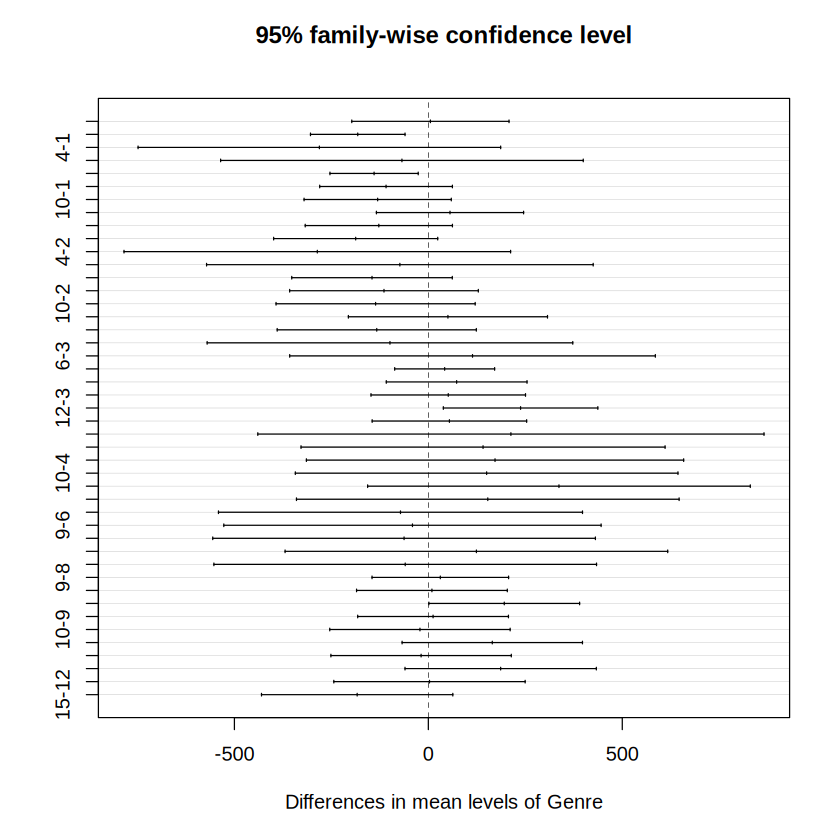

In [293]:
# produce a plot of these confidence intervals
plot(TukeyHSD(gross_Genre, conf.level = 0.95))

In [294]:
# Kiểm định shapiro
# - H0: Biến thặng dư của mô hình phân phối chuẩn
# - H1: Biến thặng dư của mô hình không phân phối
shapiro.test(residuals(gross_Genre))


	Shapiro-Wilk normality test

data:  residuals(gross_Genre)
W = 0.98717, p-value = 0.2753


In [295]:
bptest(gross_Genre)


	studentized Breusch-Pagan test

data:  gross_Genre
BP = 6.5337, df = 9, p-value = 0.6855


### Dùng log-transformation

In [296]:
# Log transformation
rm_train$Gross_transformed <- log(rm_train$Gross)

# Check the transformed values
head(rm_train)

,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers,Gross_transformed
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015,15.87518,1,351.2318,225.7210,191.40495,1,8,238.5509,28.81054,12.984306,18.72752,79.66257,5.861446
2,2014,13.15146,3,322.8139,265.2679,200.24009,1,0,283.6477,31.66941,15.184521,21.87223,21.23794,5.777076
3,2014,13.90864,3,165.1633,144.8982,61.98634,1,2,207.7172,23.41136,11.228760,14.30857,84.57906,5.106935
4,2014,19.23592,1,613.7177,299.0297,216.33018,2,5,129.5927,17.96271,6.281182,13.19680,93.52971,6.419535
5,2014,19.67423,12,554.4005,288.4880,226.38484,2,3,268.2807,28.59116,13.297119,17.88168,57.56186,6.317887
6,2014,19.67423,1,476.6686,302.1473,201.43612,1,0,290.9961,30.17700,15.835280,21.59413,87.27839,6.166821


In [297]:
leveneTest(Gross_transformed ~ Genre, data = rm_train)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,9,1.289403,0.2497851
,118,NA,NA


### Dùng box-cox

[1] "Optimal lambda: 1.03030303030303"


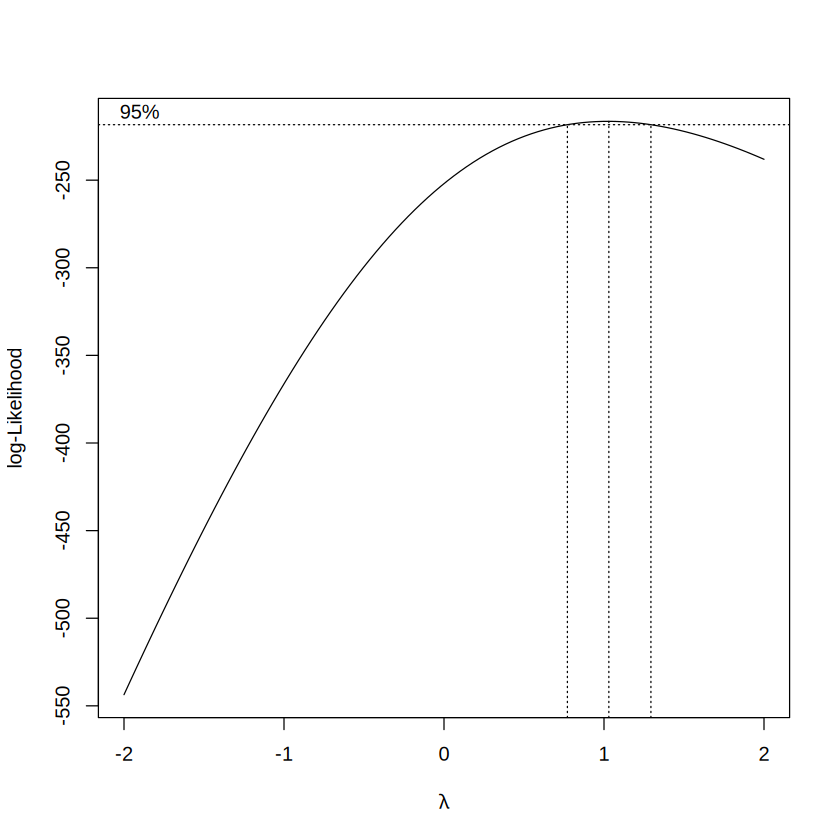

In [298]:
out <- MASS::boxcox(aov(Gross ~ Genre, data = rm_train))
lambda_optimal <- out$x[which.max(out$y)]
print(paste("Optimal lambda:", lambda_optimal))

In [299]:
# Apply the Box-Cox transformation
rm_train$Gross_transformed <- (rm_train$Gross^lambda_optimal - 1) / lambda_optimal

# Check the transformed values
head(rm_train)

,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers,Gross_transformed
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015,15.87518,1,351.2318,225.7210,191.40495,1,8,238.5509,28.81054,12.984306,18.72752,79.66257,406.1922
2,2014,13.15146,3,322.8139,265.2679,200.24009,1,0,283.6477,31.66941,15.184521,21.87223,21.23794,372.2934
3,2014,13.90864,3,165.1633,144.8982,61.98634,1,2,207.7172,23.41136,11.228760,14.30857,84.57906,186.1657
4,2014,19.23592,1,613.7177,299.0297,216.33018,2,5,129.5927,17.96271,6.281182,13.19680,93.52971,722.6112
5,2014,19.67423,12,554.4005,288.4880,226.38484,2,3,268.2807,28.59116,13.297119,17.88168,57.56186,650.6651
6,2014,19.67423,1,476.6686,302.1473,201.43612,1,0,290.9961,30.17700,15.835280,21.59413,87.27839,556.7409


In [300]:
leveneTest(Gross_transformed ~ Genre, data = rm_train)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,9,0.9329567,0.4994211
,118,NA,NA


In [301]:
processed_aov = aov(Gross_transformed ~ Genre, data = rm_train)
summary(processed_aov)

             Df  Sum Sq Mean Sq F value   Pr(>F)    
Genre         9 1186782  131865   4.574 3.47e-05 ***
Residuals   118 3402088   28831                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [302]:
##Tukey’s Honest Significance difference
TukeyHSD(processed_aov, conf.level = 0.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Gross_transformed ~ Genre, data = rm_train)

$Genre
             diff        lwr        upr     p adj
2-1      6.238084 -234.32861  246.80477 1.0000000
3-1   -216.462510 -361.13494  -71.79008 0.0001777
4-1   -334.165810 -888.94107  220.60945 0.6402207
6-1    -82.641175 -637.41643  472.13408 0.9999772
8-1   -166.491202 -301.51900  -31.46340 0.0045883
9-1   -130.314740 -333.32241   72.69293 0.5519337
10-1  -156.439601 -381.67778   68.79858 0.4359469
12-1    66.435887 -158.80230  291.67407 0.9942731
15-1  -153.203946 -378.44213   72.03424 0.4669662
3-2   -222.700593 -473.73661   28.33542 0.1287767
4-2   -340.403893 -931.89739  251.08960 0.6980901
6-2    -88.879258 -680.37275  502.61424 0.9999754
8-2   -172.729286 -418.33359   72.87502 0.4174494
9-2   -136.552823 -425.17210  152.06645 0.8790857
10-2  -162.677684 -467.34342  141.98805 0.7807716
12-2    60.197804 -244.46793  364.86354 0.9997543
15-

In [303]:
# Kiểm định shapiro
# - H0: Biến thặng dư của mô hình phân phối chuẩn
# - H1: Biến thặng dư của mô hình không phân phối
shapiro.test(residuals(processed_aov))

# Nhìn vào kết quả có p-value > 0.05 nên ta đủ điều kiện bác bỏ H0, vậy thặng dư không tuân theo phân phối chuẩn


	Shapiro-Wilk normality test

data:  residuals(processed_aov)
W = 0.98825, p-value = 0.3448


In [304]:
#  - H0: phương sai không đổi
#  - H1: phương sai thay đổi
bptest(processed_aov)

# Với giá trị p-value > 0.05, ta đủ điều kiện bác bỏ H0. Vậy phương sai không thay đổi


	studentized Breusch-Pagan test

data:  processed_aov
BP = 6.5728, df = 9, p-value = 0.6815


## Quan hệ giữa năm chiếu và doanh thu

In [310]:
rm_train$Year <- as.numeric(rm_train$Year)

In [311]:
np.csm_year.lm<- lm(Gross ~ Year * Screens, data = rm_train)
par.csm_year.lm<- lm(Gross ~ Year + Screens, data = rm_train) 

In [312]:
# which model is better? 
anova(par.csm_year.lm, np.csm_year.lm) # parallel model preferred 

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,125,1359730,NA,NA,NA,NA
2,124,1345440,1,14290.19,1.317029,0.2533353
